In [23]:
import time

import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.10Ef' % x)
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean

from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate
from sklearn.decomposition import PCA

from impyute.imputation import cs
pd.options.display.float_format = '{:20,.15f}'.format

from pprint import pprint

import copy
from sklearn.ensemble import ExtraTreesRegressor

In [24]:
# cols_to_exclude = ['genre__western', 'genre__documentary', 'genre__history', 'country__es', 'country__jp', 'country__ca', 'country__de', 'country__in', 'country__fr', 'country__ru', 'country__it', 'country__au', 'rating__nc-17', 'country__other', 'tag__satire', 'tag__neo_noir', 'tag__sadist', 'tag__cruelty', 'tag__dark', 'tag__storytelling', 'tag__sci_fi', 'tag__psychological', 'tag__absurd', 'tag__philosophical', 'tag__depressing', 'tag__plot_twist', 'tag__realism', 'tag__home_movie', 'tag__thought_provoking']
cols_to_exclude = []

def get_train_test_revenue(df):
    df['revenue'] = df['META__revenue']
    dff = df[[col for col in df.columns if not 'META' in col and not 'PROCESS' in col and not 'profitability' in col and col not in cols_to_exclude]]
    X = dff.drop(['revenue'], axis=1)
    y = dff['revenue']
    return X, y

In [25]:
df_raw = pd.read_csv('savedcsv/17_homepage.csv')
df = shuffle(df_raw, random_state=0)

num_in_train = int(df.shape[0]*0.7)
num_in_test = int(df.shape[0]*0.15)
df_train = df[:num_in_train]
df_test = df[num_in_train:num_in_train+num_in_test]
df_val = df[num_in_train+num_in_test:]
X_train, y_train = get_train_test_revenue(df_train)
X_test, y_test = get_train_test_revenue(df_test)
X_val, y_val = get_train_test_revenue(df_val)

/home/stastempaccount/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [26]:
print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

(5246, 304)
(1124, 304)
(1125, 304)


In [32]:
class Process:
    def __init__(self, 
                 X_train, X_test, X_val, y_train, y_test, y_val, 
                 imputer='mean', 
                 minmaxrange=(-1,1), 
                 standardize_X=True,
                 standardize_y=True,
                 robust_scaler=False,
                 robust_range=(0.05, 0.95),
                ):
        self.robust_scaler = robust_scaler
        self.X_train = X_train.copy()
        self.X_test = X_test.copy()
        self.X_val = X_val.copy()
        self.y_train = y_train.copy().values.reshape(-1, 1)
        self.y_test = y_test.copy().values.reshape(-1, 1)
        self.y_val = y_val.copy().values.reshape(-1, 1)
        self.imputer = imputer
        self.X_minmaxscaler = MinMaxScaler(feature_range=minmaxrange)
        self.y_minmaxscaler = MinMaxScaler(feature_range=minmaxrange)
        self.y_robust_scaler = RobustScaler(quantile_range=robust_range)
        self.X_robust_scaler = RobustScaler(quantile_range=robust_range)
        self.skewer_X = PowerTransformer(standardize=standardize_X)
        self.skewer_y = PowerTransformer(standardize=standardize_y)
        self.X_pca = PCA()

    def fill_nan(self):
        def fill_train_test(imputer):
            imputer.fit(self.X_train)
            self.X_train[:] = imputer.transform(self.X_train)
            self.X_test[:] = imputer.transform(self.X_test)
            self.X_val[:] = imputer.transform(self.X_val)

        if (self.imputer == 'mean'):
            fill_train_test(SimpleImputer(strategy='mean'))
        elif (self.imputer == 'median'):
            fill_train_test(SimpleImputer(strategy='median'))
        elif (self.imputer == 'knn'):
            fill_train_test(KNNImputer())
        elif (self.imputer == 'iterative'):
            fill_train_test(IterativeImputer(verbose=0, max_iter=50))
        elif (self.imputer == 'iterative_mlp'):
            fill_train_test(
                IterativeImputer(
                    estimator=MLPRegressor(learning_rate='adaptive', random_state=0),
                    verbose=2,
                )
            )
        return self
        
    def minmaxscale_X(self):
        def scaler_transform(obj):
            return self.X_minmaxscaler.transform(obj)
        
        self.X_minmaxscaler.fit(self.X_train)
        self.X_train[:] = scaler_transform(self.X_train)
        self.X_test[:] = scaler_transform(self.X_test)
        self.X_val[:] = scaler_transform(self.X_val)
        return self
    
    def minmaxscale_X_inverse(self, data):
        return self.X_minmaxscaler.inverse_transform(data)
    
    def minmaxscale_Y(self, inverse=False):
        def scaler_transform(obj):
            return self.y_minmaxscaler.transform(obj)

        self.y_minmaxscaler.fit(self.y_train)
        self.y_train[:] = scaler_transform(self.y_train)
        self.y_test[:] = scaler_transform(self.y_test)
        self.y_val[:] = scaler_transform(self.y_val)
        return self
    
    def minmaxscale_Y_inverse(self, data): # data is in 1d array
        return self.y_minmaxscaler.inverse_transform(data.reshape(-1, 1)).flatten()
        
    
#     def make_target_positive(self):
#         self.min_y_train = min(self.y_train)
#         self.y_train = self.y_train - self.min_y_train + 1
#         self.y_test = self.y_test - self.min_y_train + 1
#         return self
        
#     def return_target_back_from_positive(self):
#         self.y_train = self.y_train + self.min_y_train - 1
#         self.y_test = self.y_test + self.min_y_train - 1
#         return self
    
#     def return_target_back_from_positive(self, obj):
#         return obj + self.min_y_train - 1
    
    def skew_X(self, inverse=False):
        self.skewer_X.fit(self.X_train)
        self.X_train[:] = self.skewer_X.transform(self.X_train)
        self.X_test[:] = self.skewer_X.transform(self.X_test)
        self.X_val[:] = self.skewer_X.transform(self.X_val)
        return self
    
    def skew_X_inverse(self, data):
        return self.skewer_X.inverse_transform(data)
    
    def skew_y(self):
        self.skewer_y.fit(self.y_train)
        self.y_train = self.skewer_y.transform(self.y_train)
        self.y_test = self.skewer_y.transform(self.y_test)
        self.y_val = self.skewer_y.transform(self.y_val)
        return self

    def skew_y_inverse(self, data): # data is 1d ndarray
        return self.skewer_y.inverse_transform(data.reshape(-1, 1)).flatten()

    def return_processed(self):
        return self.X_train, self.X_test, self.X_val, self.y_train.flatten(), self.y_test.flatten(), self.y_val.flatten()      

In [51]:
def get_metrics(y_test, y_pred, cols):
    SS_Residual = sum((y_test - y_pred)**2)
    SS_Total = sum((y_test - np.mean(y_test))**2)
    r2 = 1 - (float(SS_Residual))/SS_Total
    adj_r2 = 1 - (1-r2)*(len(y_test) - 1)/(len(y_test) - cols -1)
    return  {
        'mape': sum(abs((y_test - y_pred)/y_test)),
        'mae': metrics.mean_absolute_error(y_test, y_pred),
        'rmse': np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
        'adj_r2': adj_r2,
    }

def print_metrics(data, y_test, y_pred, cols):
    print(data)
    res = get_metrics(y_test, y_pred, cols)
    for key in res:
#         print(f'{key}: {res[key]}')
        print(res[key])
    return res

def predict(model, model_name, X_train, y_train, X_test, y_test):
    print()
    print(model_name)
    model.fit(X_train.values, y_train)
    pred_train = model.predict(X_train.values)
    pred_test = model.predict(X_test.values)
    return {
        'res': {
            'train': print_metrics('train', y_train, pred_train, X_train.shape[1]),
            'test': print_metrics('test', y_test, pred_test, X_test.shape[1]),
        },
        'predictions':{
            'train': pred_train,
            'test': pred_test,
        },
        'actual': {
            'train': y_train,
            'test': y_test,
        },
    }


def predict_test(X_train, y_train, X_test, y_test):
    prediction_results = {}
    for model in models:
        prediction_results[model] = predict(models[model], model, X_train, y_train, X_test, y_test)
    return prediction_results

# ---------------------------------------------------------------------
def print_graphs(actual, predicted, print_log=False):
    length = len(actual)
    res_df = pd.DataFrame({'actual':actual, 'predicted': predicted}).astype(float)
    res_df.sort_values(by='actual', inplace=True)

    plt.figure()
    x = np.linspace(0, length, length)
    plt.plot(x, res_df['actual'], label='actual')
    plt.plot(x, res_df['predicted'], label='predicted')

    plt.ticklabel_format(useOffset=False, style='plain')
    plt.rcParams["figure.figsize"] = (8,8)
    if print_log:
        plt.yscale('log')
    plt.show()
    
def print_sorted_actual_to_predicted_graphs(res, process=None, train_log=False, test_log=False):
    for i in res:
        print('^^^^^^^^^^^^^^^^^^^^^^^^^^^^')
        print(i)
        print('train')
        print_graphs(res[i]['actual']['train'], res[i]['predictions']['train'], print_log=train_log)
        print('test')        
        print_graphs(res[i]['actual']['test'], res[i]['predictions']['test'], print_log=train_log)
        
        if process:
            train_real = process.skew_y_inverse(
                process.minmaxscale_Y_inverse(
                    res[i]['actual']['train']))
            test_real = process.skew_y_inverse(
                process.minmaxscale_Y_inverse(
                    res[i]['actual']['test']))
            pred_train_real = process.skew_y_inverse(
                process.minmaxscale_Y_inverse(
                    res[i]['predictions']['train']))
            pred_test_real = process.skew_y_inverse(
                process.minmaxscale_Y_inverse(
                    res[i]['predictions']['test']))

            print('train real values log')
            print_graphs(train_real, pred_train_real, print_log=True)
            print('test real values log')
            print_graphs(test_real, pred_test_real, print_log=True)
            print('train real values')
            print_graphs(train_real, pred_train_real)
            print('test real values')
            print_graphs(test_real, pred_test_real)
            
            
# ------------------------------------------------------------------
n_folds = 10
scoring = ['neg_mean_squared_error', 'explained_variance', 'r2', 'neg_mean_absolute_error']
def cv(model, X, y):
    return cross_validate(model, X.values, y, scoring=scoring, cv=10, n_jobs=-1)

def eval_model(model, name, X, y):
    start_time = time.time()
    score = cv(model, X, y)
    print('-------------------------------')
    print(name)
    means = {}
    for parameter in score:
        means[parameter] = score[parameter].mean()
        print(f'{parameter}: {means[parameter]}')
    return means

In [34]:
def get_process_and_data():
    data = {}
    process = Process(X_train, X_test, X_val, y_train, y_test, y_val, imputer='knn').skew_X().skew_y().minmaxscale_X().minmaxscale_Y().fill_nan()
    data['X_train'], data['X_test'], data['X_val'], data['y_train'], data['y_test'], data['y_val'] = process.return_processed()
    return data, process

In [35]:
data, process = get_process_and_data()

In [36]:
import pickle
with open('proc_data_001.pickle', 'wb') as handle:
    pickle.dump(data, handle)
    
with open('proc_process_001.pickle', 'wb') as handle:
    pickle.dump(process, handle)
    
# with open('proc_data_001.pickle', 'rb') as handle:
#     d2 = pickle.load(handle)
    
# with open('proc_process_001.pickle', 'rb') as handle:
#     p2 = pickle.load(handle)

In [ ]:
import lightgbm as lgb
mod_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=8,
                              learning_rate=0.05, n_estimators=650,
                              max_bin=58, bagging_fraction=0.80,
                              bagging_freq=5, feature_fraction=0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf=7, min_sum_hessian_in_leaf=11)
res_xgb = predict(mod_lgb, 'XGB',
                data['X_train'],  
                data['y_train'],
                data['X_test'],
                data['y_test'])

In [ ]:
print_metrics('train',
              process.skew_y_inverse(res_xgb['actual']['train']), 
              process.skew_y_inverse(res_xgb['predictions']['train']), 
              data['X_train'].shape[1])
print_metrics('test', 
              process.skew_y_inverse(res_xgb['actual']['test']), 
              process.skew_y_inverse(res_xgb['predictions']['test']), 
              data['X_test'].shape[1])

In [ ]:
print_sorted_actual_to_predicted_graphs({'xgb': res_xgb}, process=process)

In [ ]:
etr = ExtraTreesRegressor(n_jobs=-1, n_estimators=10000, max_features=200, min_samples_leaf=10, min_samples_split=25)
res_wo_pca = predict(etr, "ExtraTreesRegressor", 
               data['X_train'],  
               data['y_train'],
               data['X_test'],
               data['y_test'])

In [ ]:
print_metrics('train',
              process.skew_y_inverse(res_wo_pca['actual']['train']), 
              process.skew_y_inverse(res_wo_pca['predictions']['train']), 
              data['X_train'].shape[1])
print_metrics('test', 
              process.skew_y_inverse(res_wo_pca['actual']['test']), 
              process.skew_y_inverse(res_wo_pca['predictions']['test']), 
              data['X_test'].shape[1])

In [ ]:
print_sorted_actual_to_predicted_graphs({'etr': res_wo_pca}, process=process)

In [ ]:
pca = PCA(.99)

In [ ]:
pca.fit(data['X_train'].values)

In [ ]:
pca.n_components_

In [ ]:
data_pca = copy.deepcopy(data)

In [ ]:
data_pca['X_train'] = pca.transform(data['X_train'])
data_pca['X_test'] = pca.transform(data['X_test'])

In [ ]:
etr = ExtraTreesRegressor(n_jobs=-1, n_estimators=10000, max_features=200, min_samples_leaf=10, min_samples_split=25)
res = predict(etr, "ExtraTreesRegressor", 
               pd.DataFrame(data_pca['X_train']),  
               data_pca['y_train'],
               pd.DataFrame(data_pca['X_test']),
               data_pca['y_test'])

In [ ]:
print_metrics('train',
              process.skew_y_inverse(res['actual']['train']), 
              process.skew_y_inverse(res['predictions']['train']), 
              data_pca['X_train'].shape[1])
print_metrics('test', 
              process.skew_y_inverse(res['actual']['test']), 
              process.skew_y_inverse(res['predictions']['test']), 
              data_pca['X_test'].shape[1])

In [ ]:
print_sorted_actual_to_predicted_graphs({'etr': res}, process=process)

In [ ]:
data['X_train'].shape

In [ ]:
pca_auto = PCA(n_components='mle')
pca_auto.fit(data['X_train'].values)

In [ ]:
pca_auto.n_components_

In [ ]:
data_pca_mle = copy.deepcopy(data)
data_pca_mle['X_train'] = pca_auto.transform(data['X_train'])
data_pca_mle['X_test'] = pca_auto.transform(data['X_test'])

In [ ]:
etr_auto = ExtraTreesRegressor(n_jobs=-1, n_estimators=10000, min_samples_leaf=10, min_samples_split=25)
res_auto = predict(etr_auto, "ExtraTreesRegressor", 
               pd.DataFrame(data_pca_mle['X_train']),  
               data_pca_mle['y_train'],
               pd.DataFrame(data_pca_mle['X_test']),
               data_pca_mle['y_test'])

In [ ]:
pd.DataFrame(data_pca_mle['X_train']).describe()

In [ ]:
print_metrics('train',
              process.skew_y_inverse(res_auto['actual']['train']), 
              process.skew_y_inverse(res_auto['predictions']['train']), 
              data_pca_mle['X_train'].shape[1])
print_metrics('test', 
              process.skew_y_inverse(res_auto['actual']['test']), 
              process.skew_y_inverse(res_auto['predictions']['test']), 
              data_pca_mle['X_test'].shape[1])

In [ ]:
print_sorted_actual_to_predicted_graphs({'etr_auto': res_auto}, process=process)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(
    n_estimators=1000,
    learning_rate=0.0001,
    min_samples_leaf=10,
    min_samples_split=25
)

In [ ]:
res_gbr = predict(gbr, "GradientBoostingRegressor", 
               pd.DataFrame(data['X_train']),  
               data['y_train'],
               pd.DataFrame(data['X_test']),
               data['y_test'])

In [ ]:
print_metrics('train',
              process.skew_y_inverse(res_gbr['actual']['train']), 
              process.skew_y_inverse(res_gbr['predictions']['train']), 
              data_pca_mle['X_train'].shape[1])
print_metrics('test', 
              process.skew_y_inverse(res_gbr['actual']['test']), 
              process.skew_y_inverse(res_gbr['predictions']['test']), 
              data_pca_mle['X_test'].shape[1])
print_sorted_actual_to_predicted_graphs({'gbr': res_gbr}, process=process)

In [ ]:
print_metrics('train',
              process.skew_y_inverse(res_gbr['actual']['train']), 
              process.skew_y_inverse(res_gbr['predictions']['train']), 
              data_pca_mle['X_train'].shape[1])
print_metrics('test', 
              process.skew_y_inverse(res_gbr['actual']['test']), 
              process.skew_y_inverse(res_gbr['predictions']['test']), 
              data_pca_mle['X_test'].shape[1])
print_sorted_actual_to_predicted_graphs({'gbr': res_gbr}, process=process)

In [ ]:
# grid search gradient boosting regressor
from sklearn.model_selection import GridSearchCV

model = GradientBoostingRegressor(verbose=2)
                            
gsc = GridSearchCV(
    estimator=model,
    param_grid={
        'n_estimators': [100, 500],
        'loss': ['ls', 'lad', 'huber'],
        'learning_rate': [0.001, 0.0001],
        'subsample': [0.9, 0.8, 0.7],
        'max_depth': [3,5,7],
        'min_samples_split': [5, 10, 15],
        'min_samples_leaf': [1, 5],
    },
    scoring='neg_root_mean_squared_error',
    cv=5
)

grid_result = gsc.fit(data['X_train'], data['y_train'])

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


for test_mean, param in zip(
        grid_result.cv_results_['mean_test_score'],
        grid_result.cv_results_['params']):
    print("Test : %f with: %r" % (test_mean, param))

In [37]:
def predict_nn(model, model_name, X_train, y_train, X_test, y_test):
    print()
    print(model_name)
    pred_train = model.predict(X_train.values).flatten()
    pred_test = model.predict(X_test.values).flatten()
    return {
        'res': {
            'train': print_metrics_nn('train', y_train, pred_train, X_train.shape[1]),
            'test': print_metrics_nn('test', y_test, pred_test, X_test.shape[1]),
        },
        'predictions':{
            'train': pred_train,
            'test': pred_test,
        },
        'actual': {
            'train': y_train,
            'test': y_test,
        },
    }

def print_metrics_nn(data, y_test, y_pred, cols):
    print(data)
    res = get_metrics_nn(y_test, y_pred, cols)
    for key in res:
        print(f'{key}: {res[key]}')
    return res

def get_metrics_nn(y_test, y_pred, cols):
    SS_Residual = sum((y_test - y_pred)**2)
    SS_Total = sum((y_test - np.mean(y_test))**2)
    r2 = 1 - (float(SS_Residual))/SS_Total
    adj_r2 = 1 - (1-r2)*(len(y_test) - 1)/(len(y_test) - cols -1)
    return  {
        'mape': (abs((y_test - y_pred)/y_test)).mean(),
        'mae': metrics.mean_absolute_error(y_test, y_pred),
        'rmse': np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
        'adj_r2': adj_r2,
    }

In [38]:
def output_metrics(model, data, process):
    res = predict_nn(model, "Keras NN", 
                   data['X_train'],  
                   data['y_train'],
                   data['X_val'],
                   data['y_val'])
#                    data['X_test'],
#                    data['y_test'])

    print('\nReturned back\n')

    print_metrics_nn('train',
                  process.skew_y_inverse(
                      process.minmaxscale_Y_inverse(res['actual']['train'])), 
                  process.skew_y_inverse(
                      process.minmaxscale_Y_inverse(res['predictions']['train'])), 
                  data['X_train'].shape[1])
    print_metrics_nn('test', 
                  process.skew_y_inverse(
                      process.minmaxscale_Y_inverse(res['actual']['test'])), 
                  process.skew_y_inverse(
                      process.minmaxscale_Y_inverse(res['predictions']['test'])), 
                  data['X_test'].shape[1])
    print_sorted_actual_to_predicted_graphs({'nn': res}, process=process)

In [44]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Activation, Dropout
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.initializers import GlorotNormal, GlorotUniform, he_normal, he_uniform
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adamax
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras import backend as K

print(tf.__version__)

2.2.0


In [45]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [46]:
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

In [47]:
def get_data():
    with open('proc_data_001.pickle', 'rb') as handle:
        d = pickle.load(handle)
        X_train = d['X_train']
        y_train = d['y_train']
        X_test = d['X_test']
        y_test = d['y_test']
        return X_train, y_train, X_test, y_test

In [16]:
# def model(X_train, y_train, X_test, y_test):
    
#     model = tf.keras.Sequential()
#     model.add(Dense(
#         {{choice([128, 256, 512, 1024, 2048])}}, 
#         input_shape=(225,),
#         kernel_initializer={{choice(['zeros', 'glorot_normal', 'he_normal'])}},           
#         bias_initializer={{choice(['zeros', 'glorot_normal', 'he_normal'])}},  
#         kernel_regularizer=l1_l2(
#             l1={{choice([0.1, 0.01, 0.001, 0.0001, 0.00001, 0])}}, 
#             l2={{choice([0.1, 0.01, 0.001, 0.0001, 0.00001, 0])}}),
#         bias_regularizer=l1_l2(
#             l1={{choice([0.1, 0.01, 0.001, 0.0001, 0.00001, 0])}}, 
#             l2={{choice([0.1, 0.01, 0.001, 0.0001, 0.00001, 0])}}),
#         activity_regularizer=l1_l2(
#             l1={{choice([0.1, 0.01, 0.001, 0.0001, 0.00001, 0])}}, 
#             l2={{choice([0.1, 0.01, 0.001, 0.0001, 0.00001, 0])}})))
#     model.add(Activation({{choice(['sigmoid', 'relu', 'tanh'])}}))
#     if {{choice(['bn1_yes', 'bn1_no'])}} == 'bn1_yes':
#         model.add(BatchNormalization())
#     model.add(Dropout({{uniform(0, 1)}}))
#     model.add(Dense(
#         {{choice([128, 256, 512, 1024, 2048])}},
#         kernel_initializer={{choice(['zeros', 'glorot_normal', 'he_normal'])}},           
#         bias_initializer={{choice(['zeros', 'glorot_normal', 'he_normal'])}},          
#         kernel_regularizer=l1_l2(
#             l1={{choice([0.1, 0.01, 0.001, 0.0001, 0.00001, 0])}}, 
#             l2={{choice([0.1, 0.01, 0.001, 0.0001, 0.00001, 0])}}),
#         bias_regularizer=l1_l2(
#             l1={{choice([0.1, 0.01, 0.001, 0.0001, 0.00001, 0])}}, 
#             l2={{choice([0.1, 0.01, 0.001, 0.0001, 0.00001, 0])}}),
#         activity_regularizer=l1_l2(
#             l1={{choice([0.1, 0.01, 0.001, 0.0001, 0.00001, 0])}}, 
#             l2={{choice([0.1, 0.01, 0.001, 0.0001, 0.00001, 0])}})))
#     model.add(Activation({{choice(['sigmoid', 'relu', 'tanh'])}}))
#     if {{choice(['bn2_yes', 'bn2_no'])}} == 'bn2_yes':
#         model.add(BatchNormalization())
#     model.add(Dropout({{uniform(0, 1)}}))
    
#     if {{choice(['two', 'three'])}} == 'three':
#         model.add(Dense(
#             {{choice([128, 256, 512, 1024, 2048])}},
#             kernel_initializer={{choice(['zeros', 'glorot_normal', 'he_normal'])}},           
#             bias_initializer={{choice(['zeros', 'glorot_normal', 'he_normal'])}},  
#             kernel_regularizer=l1_l2(
#                 l1={{choice([0.1, 0.01, 0.001, 0.0001, 0.00001, 0])}}, 
#                 l2={{choice([0.1, 0.01, 0.001, 0.0001, 0.00001, 0])}}),
#             bias_regularizer=l1_l2(
#                 l1={{choice([0.1, 0.01, 0.001, 0.0001, 0.00001, 0])}}, 
#                 l2={{choice([0.1, 0.01, 0.001, 0.0001, 0.00001, 0])}}),
#             activity_regularizer=l1_l2(
#                 l1={{choice([0.1, 0.01, 0.001, 0.0001, 0.00001, 0])}}, 
#                 l2={{choice([0.1, 0.01, 0.001, 0.0001, 0.00001, 0])}})))
#         if {{choice(['bn3_yes', 'bn3_no'])}} == 'bn3_yes':
#             model.add(BatchNormalization())
#         model.add(Activation({{choice(['sigmoid', 'relu', 'tanh'])}}))
#         model.add(Dropout({{uniform(0, 1)}}))
        
#     model.add(Dense(1))
        
#     model.compile(loss='mse', 
#                   metrics=['mae'],
#                   optimizer={{choice(['rmsprop', 'adam', 'sgd'])}})

#     es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
#     model.fit(X_train, y_train,
#               batch_size={{choice([16, 32, 64, 128, 256, 512])}},
#               epochs=100,
#               verbose=2,
#               validation_data=(X_test, y_test),
# #               validation_split=0.15,
#               callbacks=[es])

#     mse, mae = model.evaluate(X_test, y_test, verbose=1)
#     print('Test mse:', mse)
#     return {'loss': mse, 'status': STATUS_OK, 'model': model}

def model(X_train, y_train, X_test, y_test):
    
    model = tf.keras.Sequential()
    model.add(Dense(
        256,
        input_shape=(225,),
        kernel_initializer='glorot_normal',
        activation='sigmoid', 
        kernel_regularizer=keras.regularizers.l1_l2(l1=0.0001, l2=0.0001),
        bias_regularizer=keras.regularizers.l1_l2(l1=0.001, l2=0.1)))        
    model.add(Dropout(0.005))
    model.add(Dense(
        256,
        activation='sigmoid',
        kernel_initializer='glorot_normal', 
        kernel_regularizer=keras.regularizers.l1_l2(l1=0, l2=0.001),
        bias_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01)))
    model.add(Dropout(0.5))
        
    model.add(Dense(
        1,
        kernel_initializer='glorot_normal',
        activation='linear'
    ))
    
    adamax = keras.optimizers.Adamax(
        learning_rate={{choice([0.1, 0.01, 0.001, 0.0001, 0.00001])}},
        beta_1={{choice([0.5, 0.75, 0.85, 0.9, 0.95, 0.99, 0.999, 0.9999])}},
        beta_2={{choice([0.5, 0.75, 0.85, 0.9, 0.95, 0.99, 0.999, 0.9999])}})
        
    model.compile(loss='mse', 
                  metrics=['mae'],
                  optimizer=adamax)

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    model.fit(X_train, y_train,
              batch_size=256,
              epochs=500,
              verbose=2,
              shuffle=True,
              validation_data=(X_test, y_test),
#               validation_split=0.15,
              callbacks=[es])

    mse, mae = model.evaluate(X_test, y_test, verbose=1)
    print('Test mse:', mse)
    return {'loss': mse, 'status': STATUS_OK, 'model': model}

In [17]:
X_train, y_train, X_test, y_test = get_data()

best_run = None
best_model = None
space = None
best_run, best_model, space = optim.minimize(model=model,
                                      data=get_data,
                                      algo=tpe.suggest,
                                      max_evals=30,
                                      trials=Trials(),
                                      notebook_name='keras',
                                      eval_space=True,
                                      return_space=True)

>>> Imports:
#coding=utf-8

try:
    import time
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    import seaborn as sns
except:
    pass

try:
    from statistics import mean
except:
    pass

try:
    from sklearn import metrics
except:
    pass

try:
    from sklearn.utils import shuffle
except:
    pass

try:
    from sklearn.impute import SimpleImputer
except:
    pass

try:
    from sklearn.neural_network import MLPRegressor
except:
    pass

try:
    from sklearn.preprocessing import MinMaxScaler
except:
    pass

try:
    from sklearn.preprocessing import PowerTransformer
except:
    pass

try:
    from sklearn.experimental import enable_iterative_imputer
except:
    pass

try:
    from sklearn.impute import IterativeImputer
except:
    pass

try:
    from sklearn.impute import KNNImputer
except:
    pass

try:
    from sklearn.impute import SimpleImp

Epoch 4/500                                                                
21/21 - 0s - loss: 2.1967 - mae: 1.0113 - val_loss: 1.5562 - val_mae: 0.7859

Epoch 5/500                                                                
21/21 - 0s - loss: 2.1878 - mae: 1.0027 - val_loss: 1.5270 - val_mae: 0.7740

Epoch 6/500                                                                
21/21 - 0s - loss: 2.1598 - mae: 1.0022 - val_loss: 1.5038 - val_mae: 0.7644

Epoch 7/500                                                                
21/21 - 0s - loss: 2.1377 - mae: 0.9978 - val_loss: 1.4855 - val_mae: 0.7568

Epoch 8/500                                                                
21/21 - 0s - loss: 2.1245 - mae: 0.9928 - val_loss: 1.4702 - val_mae: 0.7504

Epoch 9/500                                                                
21/21 - 0s - loss: 2.1133 - mae: 0.9897 - val_loss: 1.4573 - val_mae: 0.7451

Epoch 10/500                                                               


Epoch 57/500                                                               
21/21 - 0s - loss: 1.6734 - mae: 0.8370 - val_loss: 1.1818 - val_mae: 0.6112

Epoch 58/500                                                               
21/21 - 0s - loss: 1.6018 - mae: 0.8038 - val_loss: 1.1792 - val_mae: 0.6099

Epoch 59/500                                                               
21/21 - 0s - loss: 1.6755 - mae: 0.8351 - val_loss: 1.1763 - val_mae: 0.6085

Epoch 60/500                                                               
21/21 - 0s - loss: 1.6146 - mae: 0.8170 - val_loss: 1.1737 - val_mae: 0.6073

Epoch 61/500                                                               
21/21 - 0s - loss: 1.6174 - mae: 0.8120 - val_loss: 1.1716 - val_mae: 0.6061

Epoch 62/500                                                               
21/21 - 0s - loss: 1.6306 - mae: 0.8176 - val_loss: 1.1689 - val_mae: 0.6049

Epoch 63/500                                                               


Epoch 110/500                                                              
21/21 - 0s - loss: 1.4183 - mae: 0.7322 - val_loss: 1.0984 - val_mae: 0.5698

Epoch 111/500                                                              
21/21 - 0s - loss: 1.4459 - mae: 0.7395 - val_loss: 1.0977 - val_mae: 0.5693

Epoch 112/500                                                              
21/21 - 0s - loss: 1.4419 - mae: 0.7435 - val_loss: 1.0965 - val_mae: 0.5688

Epoch 113/500                                                              
21/21 - 0s - loss: 1.4525 - mae: 0.7481 - val_loss: 1.0954 - val_mae: 0.5684

Epoch 114/500                                                              
21/21 - 0s - loss: 1.4377 - mae: 0.7375 - val_loss: 1.0943 - val_mae: 0.5679

Epoch 115/500                                                              
21/21 - 0s - loss: 1.4503 - mae: 0.7459 - val_loss: 1.0931 - val_mae: 0.5676

Epoch 116/500                                                              


Epoch 163/500                                                              
21/21 - 0s - loss: 1.3013 - mae: 0.6829 - val_loss: 1.0524 - val_mae: 0.5475

Epoch 164/500                                                              
21/21 - 0s - loss: 1.2825 - mae: 0.6712 - val_loss: 1.0521 - val_mae: 0.5470

Epoch 165/500                                                              
21/21 - 0s - loss: 1.2834 - mae: 0.6721 - val_loss: 1.0511 - val_mae: 0.5467

Epoch 166/500                                                              
21/21 - 0s - loss: 1.3013 - mae: 0.6841 - val_loss: 1.0505 - val_mae: 0.5463

Epoch 167/500                                                              
21/21 - 0s - loss: 1.3053 - mae: 0.6827 - val_loss: 1.0495 - val_mae: 0.5460

Epoch 168/500                                                              
21/21 - 0s - loss: 1.3026 - mae: 0.6826 - val_loss: 1.0488 - val_mae: 0.5456

Epoch 169/500                                                              


Epoch 216/500                                                              
21/21 - 0s - loss: 1.2176 - mae: 0.6396 - val_loss: 1.0180 - val_mae: 0.5314

Epoch 217/500                                                              
21/21 - 0s - loss: 1.2085 - mae: 0.6394 - val_loss: 1.0173 - val_mae: 0.5313

Epoch 218/500                                                              
21/21 - 0s - loss: 1.1876 - mae: 0.6314 - val_loss: 1.0168 - val_mae: 0.5311

Epoch 219/500                                                              
21/21 - 0s - loss: 1.2028 - mae: 0.6354 - val_loss: 1.0162 - val_mae: 0.5309

Epoch 220/500                                                              
21/21 - 0s - loss: 1.1940 - mae: 0.6274 - val_loss: 1.0157 - val_mae: 0.5305

Epoch 221/500                                                              
21/21 - 0s - loss: 1.1970 - mae: 0.6333 - val_loss: 1.0151 - val_mae: 0.5303

Epoch 222/500                                                              


Epoch 269/500                                                              
21/21 - 0s - loss: 1.1241 - mae: 0.6016 - val_loss: 0.9911 - val_mae: 0.5201

Epoch 270/500                                                              
21/21 - 0s - loss: 1.1405 - mae: 0.6136 - val_loss: 0.9907 - val_mae: 0.5199

Epoch 271/500                                                              
21/21 - 0s - loss: 1.1352 - mae: 0.6062 - val_loss: 0.9902 - val_mae: 0.5198

Epoch 272/500                                                              
21/21 - 0s - loss: 1.1348 - mae: 0.6058 - val_loss: 0.9897 - val_mae: 0.5197

Epoch 273/500                                                              
21/21 - 0s - loss: 1.1216 - mae: 0.5979 - val_loss: 0.9893 - val_mae: 0.5195

Epoch 274/500                                                              
21/21 - 0s - loss: 1.1361 - mae: 0.6060 - val_loss: 0.9890 - val_mae: 0.5193

Epoch 275/500                                                              


Epoch 322/500                                                              
21/21 - 0s - loss: 1.0744 - mae: 0.5785 - val_loss: 0.9699 - val_mae: 0.5123

Epoch 323/500                                                              
21/21 - 0s - loss: 1.0842 - mae: 0.5794 - val_loss: 0.9696 - val_mae: 0.5122

Epoch 324/500                                                              
21/21 - 0s - loss: 1.0777 - mae: 0.5799 - val_loss: 0.9692 - val_mae: 0.5120

Epoch 325/500                                                              
21/21 - 0s - loss: 1.0780 - mae: 0.5808 - val_loss: 0.9689 - val_mae: 0.5119

Epoch 326/500                                                              
21/21 - 0s - loss: 1.0726 - mae: 0.5789 - val_loss: 0.9685 - val_mae: 0.5117

Epoch 327/500                                                              
21/21 - 0s - loss: 1.0881 - mae: 0.5850 - val_loss: 0.9681 - val_mae: 0.5116

Epoch 328/500                                                              


Epoch 375/500                                                              
21/21 - 0s - loss: 1.0330 - mae: 0.5539 - val_loss: 0.9516 - val_mae: 0.5064

Epoch 376/500                                                              
21/21 - 0s - loss: 1.0476 - mae: 0.5676 - val_loss: 0.9513 - val_mae: 0.5062

Epoch 377/500                                                              
21/21 - 0s - loss: 1.0425 - mae: 0.5598 - val_loss: 0.9510 - val_mae: 0.5061

Epoch 378/500                                                              
21/21 - 0s - loss: 1.0342 - mae: 0.5584 - val_loss: 0.9505 - val_mae: 0.5061

Epoch 379/500                                                              
21/21 - 0s - loss: 1.0284 - mae: 0.5566 - val_loss: 0.9501 - val_mae: 0.5061

Epoch 380/500                                                              
21/21 - 0s - loss: 1.0397 - mae: 0.5647 - val_loss: 0.9498 - val_mae: 0.5061

Epoch 381/500                                                              


Epoch 428/500                                                              
21/21 - 0s - loss: 1.0053 - mae: 0.5482 - val_loss: 0.9351 - val_mae: 0.5020

Epoch 429/500                                                              
21/21 - 0s - loss: 1.0014 - mae: 0.5456 - val_loss: 0.9348 - val_mae: 0.5019

Epoch 430/500                                                              
21/21 - 0s - loss: 1.0081 - mae: 0.5510 - val_loss: 0.9346 - val_mae: 0.5017

Epoch 431/500                                                              
21/21 - 0s - loss: 1.0032 - mae: 0.5460 - val_loss: 0.9342 - val_mae: 0.5017

Epoch 432/500                                                              
21/21 - 0s - loss: 1.0087 - mae: 0.5504 - val_loss: 0.9339 - val_mae: 0.5017

Epoch 433/500                                                              
21/21 - 0s - loss: 0.9979 - mae: 0.5423 - val_loss: 0.9335 - val_mae: 0.5017

Epoch 434/500                                                              


Epoch 481/500                                                              
21/21 - 0s - loss: 0.9793 - mae: 0.5365 - val_loss: 0.9196 - val_mae: 0.4983

Epoch 482/500                                                              
21/21 - 0s - loss: 0.9812 - mae: 0.5358 - val_loss: 0.9193 - val_mae: 0.4981

Epoch 483/500                                                              
21/21 - 0s - loss: 0.9735 - mae: 0.5348 - val_loss: 0.9190 - val_mae: 0.4983

Epoch 484/500                                                              
21/21 - 0s - loss: 0.9667 - mae: 0.5320 - val_loss: 0.9187 - val_mae: 0.4981

Epoch 485/500                                                              
21/21 - 0s - loss: 0.9679 - mae: 0.5317 - val_loss: 0.9184 - val_mae: 0.4980

Epoch 486/500                                                              
21/21 - 0s - loss: 0.9656 - mae: 0.5288 - val_loss: 0.9182 - val_mae: 0.4978

Epoch 487/500                                                              


Epoch 29/500                                                                    
21/21 - 0s - loss: 0.7596 - mae: 0.4793 - val_loss: 0.7410 - val_mae: 0.4687    

Epoch 30/500                                                                    
21/21 - 0s - loss: 0.7547 - mae: 0.4805 - val_loss: 0.7340 - val_mae: 0.4683    

Epoch 31/500                                                                    
21/21 - 0s - loss: 0.7474 - mae: 0.4823 - val_loss: 0.7258 - val_mae: 0.4665    

Epoch 32/500                                                                    
21/21 - 0s - loss: 0.7354 - mae: 0.4756 - val_loss: 0.7177 - val_mae: 0.4660    

Epoch 33/500                                                                    
21/21 - 0s - loss: 0.7304 - mae: 0.4783 - val_loss: 0.7110 - val_mae: 0.4644    

Epoch 34/500                                                                    
21/21 - 0s - loss: 0.7187 - mae: 0.4749 - val_loss: 0.7025 - val_mae: 0.4630    

Epoch 35/500          

Epoch 79/500                                                                    
21/21 - 0s - loss: 0.4999 - mae: 0.4460 - val_loss: 0.5040 - val_mae: 0.4450    

Epoch 80/500                                                                    
21/21 - 0s - loss: 0.4992 - mae: 0.4469 - val_loss: 0.5016 - val_mae: 0.4446    

Epoch 81/500                                                                    
21/21 - 0s - loss: 0.4951 - mae: 0.4443 - val_loss: 0.4996 - val_mae: 0.4452    

Epoch 82/500                                                                    
21/21 - 0s - loss: 0.4943 - mae: 0.4452 - val_loss: 0.4969 - val_mae: 0.4444    

Epoch 83/500                                                                    
21/21 - 0s - loss: 0.4891 - mae: 0.4423 - val_loss: 0.4944 - val_mae: 0.4452    

Epoch 84/500                                                                    
21/21 - 0s - loss: 0.4915 - mae: 0.4475 - val_loss: 0.4930 - val_mae: 0.4446    

Epoch 85/500          

Epoch 129/500                                                                   
21/21 - 0s - loss: 0.4154 - mae: 0.4433 - val_loss: 0.4218 - val_mae: 0.4438    

Epoch 130/500                                                                   
21/21 - 0s - loss: 0.4160 - mae: 0.4429 - val_loss: 0.4212 - val_mae: 0.4440    

Epoch 131/500                                                                   
21/21 - 0s - loss: 0.4126 - mae: 0.4409 - val_loss: 0.4211 - val_mae: 0.4432    

Epoch 132/500                                                                   
21/21 - 0s - loss: 0.4083 - mae: 0.4394 - val_loss: 0.4195 - val_mae: 0.4444    

Epoch 133/500                                                                   
21/21 - 0s - loss: 0.4066 - mae: 0.4377 - val_loss: 0.4185 - val_mae: 0.4442    

Epoch 134/500                                                                   
21/21 - 0s - loss: 0.4132 - mae: 0.4441 - val_loss: 0.4175 - val_mae: 0.4435    

Epoch 135/500         

Epoch 179/500                                                                   
21/21 - 0s - loss: 0.3899 - mae: 0.4409 - val_loss: 0.4035 - val_mae: 0.4451    

Epoch 180/500                                                                   
21/21 - 0s - loss: 0.3919 - mae: 0.4415 - val_loss: 0.4048 - val_mae: 0.4460    

Epoch 181/500                                                                   
21/21 - 0s - loss: 0.3905 - mae: 0.4418 - val_loss: 0.4064 - val_mae: 0.4466    

Epoch 182/500                                                                   
21/21 - 0s - loss: 0.3842 - mae: 0.4388 - val_loss: 0.4007 - val_mae: 0.4433    

Epoch 183/500                                                                   
21/21 - 0s - loss: 0.3863 - mae: 0.4386 - val_loss: 0.3984 - val_mae: 0.4433    

Epoch 184/500                                                                   
21/21 - 0s - loss: 0.3875 - mae: 0.4391 - val_loss: 0.3990 - val_mae: 0.4452    

Epoch 185/500         

Epoch 229/500                                                                   
21/21 - 0s - loss: 0.3839 - mae: 0.4397 - val_loss: 0.3984 - val_mae: 0.4474    

Epoch 230/500                                                                   
21/21 - 0s - loss: 0.3868 - mae: 0.4430 - val_loss: 0.3967 - val_mae: 0.4439    

Epoch 231/500                                                                   
21/21 - 0s - loss: 0.3867 - mae: 0.4407 - val_loss: 0.3966 - val_mae: 0.4437    

Epoch 232/500                                                                   
21/21 - 0s - loss: 0.3785 - mae: 0.4355 - val_loss: 0.3962 - val_mae: 0.4432    

Epoch 233/500                                                                   
21/21 - 0s - loss: 0.3832 - mae: 0.4419 - val_loss: 0.3972 - val_mae: 0.4440    

Epoch 234/500                                                                   
21/21 - 0s - loss: 0.3853 - mae: 0.4399 - val_loss: 0.3958 - val_mae: 0.4429    

Epoch 235/500         

Epoch 24/500                                                                     
21/21 - 0s - loss: 0.5245 - mae: 0.4967 - val_loss: 0.4772 - val_mae: 0.4548     

Epoch 25/500                                                                     
21/21 - 0s - loss: 0.5223 - mae: 0.4934 - val_loss: 0.4805 - val_mae: 0.4618     

Epoch 26/500                                                                     
21/21 - 0s - loss: 0.4926 - mae: 0.4780 - val_loss: 0.5157 - val_mae: 0.4969     

Epoch 27/500                                                                     
21/21 - 0s - loss: 0.4848 - mae: 0.4743 - val_loss: 0.4733 - val_mae: 0.4636     

Epoch 28/500                                                                     
21/21 - 0s - loss: 0.4807 - mae: 0.4746 - val_loss: 0.4590 - val_mae: 0.4522     

Epoch 29/500                                                                     
21/21 - 0s - loss: 0.4787 - mae: 0.4729 - val_loss: 0.4943 - val_mae: 0.4744     

Epoch 30/5

21/21 - 0s - loss: 1.1051 - mae: 0.5906 - val_loss: 0.9773 - val_mae: 0.5157     

Epoch 18/500                                                                     
21/21 - 0s - loss: 1.0811 - mae: 0.5804 - val_loss: 0.9692 - val_mae: 0.5133     

Epoch 19/500                                                                     
21/21 - 0s - loss: 1.0840 - mae: 0.5817 - val_loss: 0.9629 - val_mae: 0.5110     

Epoch 20/500                                                                     
21/21 - 0s - loss: 1.0576 - mae: 0.5699 - val_loss: 0.9561 - val_mae: 0.5090     

Epoch 21/500                                                                     
21/21 - 0s - loss: 1.0419 - mae: 0.5611 - val_loss: 0.9504 - val_mae: 0.5073     

Epoch 22/500                                                                     
21/21 - 0s - loss: 1.0406 - mae: 0.5641 - val_loss: 0.9450 - val_mae: 0.5058     

Epoch 23/500                                                                     
21/21 - 0s

Epoch 67/500                                                                     
21/21 - 0s - loss: 0.7596 - mae: 0.4765 - val_loss: 0.7534 - val_mae: 0.4728     

Epoch 68/500                                                                     
21/21 - 0s - loss: 0.7571 - mae: 0.4766 - val_loss: 0.7494 - val_mae: 0.4729     

Epoch 69/500                                                                     
21/21 - 0s - loss: 0.7473 - mae: 0.4716 - val_loss: 0.7460 - val_mae: 0.4723     

Epoch 70/500                                                                     
21/21 - 0s - loss: 0.7449 - mae: 0.4722 - val_loss: 0.7425 - val_mae: 0.4718     

Epoch 71/500                                                                     
21/21 - 0s - loss: 0.7362 - mae: 0.4675 - val_loss: 0.7391 - val_mae: 0.4710     

Epoch 72/500                                                                     
21/21 - 0s - loss: 0.7334 - mae: 0.4670 - val_loss: 0.7358 - val_mae: 0.4710     

Epoch 73/5

21/21 - 0s - loss: 0.6053 - mae: 0.4516 - val_loss: 0.6153 - val_mae: 0.4565     

Epoch 117/500                                                                    
21/21 - 0s - loss: 0.6025 - mae: 0.4521 - val_loss: 0.6133 - val_mae: 0.4564     

Epoch 118/500                                                                    
21/21 - 0s - loss: 0.5987 - mae: 0.4489 - val_loss: 0.6109 - val_mae: 0.4565     

Epoch 119/500                                                                    
21/21 - 0s - loss: 0.6004 - mae: 0.4510 - val_loss: 0.6089 - val_mae: 0.4560     

Epoch 120/500                                                                    
21/21 - 0s - loss: 0.5953 - mae: 0.4505 - val_loss: 0.6074 - val_mae: 0.4559     

Epoch 121/500                                                                    
21/21 - 0s - loss: 0.5955 - mae: 0.4519 - val_loss: 0.6046 - val_mae: 0.4553     

Epoch 122/500                                                                    
21/21 - 0s

Epoch 166/500                                                                    
21/21 - 0s - loss: 0.5155 - mae: 0.4430 - val_loss: 0.5295 - val_mae: 0.4489     

Epoch 167/500                                                                    
21/21 - 0s - loss: 0.5154 - mae: 0.4427 - val_loss: 0.5286 - val_mae: 0.4509     

Epoch 168/500                                                                    
21/21 - 0s - loss: 0.5164 - mae: 0.4434 - val_loss: 0.5273 - val_mae: 0.4488     

Epoch 169/500                                                                    
21/21 - 0s - loss: 0.5150 - mae: 0.4425 - val_loss: 0.5255 - val_mae: 0.4493     

Epoch 170/500                                                                    
21/21 - 0s - loss: 0.5151 - mae: 0.4456 - val_loss: 0.5243 - val_mae: 0.4490     

Epoch 171/500                                                                    
21/21 - 0s - loss: 0.5145 - mae: 0.4464 - val_loss: 0.5233 - val_mae: 0.4490     

Epoch 172/

21/21 - 0s - loss: 0.4656 - mae: 0.4400 - val_loss: 0.4792 - val_mae: 0.4461     

Epoch 216/500                                                                    
21/21 - 0s - loss: 0.4642 - mae: 0.4379 - val_loss: 0.4783 - val_mae: 0.4466     

Epoch 217/500                                                                    
21/21 - 0s - loss: 0.4679 - mae: 0.4410 - val_loss: 0.4779 - val_mae: 0.4464     

Epoch 218/500                                                                    
21/21 - 0s - loss: 0.4670 - mae: 0.4425 - val_loss: 0.4771 - val_mae: 0.4462     

Epoch 219/500                                                                    
21/21 - 0s - loss: 0.4651 - mae: 0.4424 - val_loss: 0.4762 - val_mae: 0.4465     

Epoch 220/500                                                                    
21/21 - 0s - loss: 0.4613 - mae: 0.4386 - val_loss: 0.4755 - val_mae: 0.4467     

Epoch 221/500                                                                    
21/21 - 0s

Epoch 265/500                                                                    
21/21 - 0s - loss: 0.4380 - mae: 0.4403 - val_loss: 0.4480 - val_mae: 0.4451     

Epoch 266/500                                                                    
21/21 - 0s - loss: 0.4347 - mae: 0.4385 - val_loss: 0.4475 - val_mae: 0.4451     

Epoch 267/500                                                                    
21/21 - 0s - loss: 0.4342 - mae: 0.4411 - val_loss: 0.4474 - val_mae: 0.4450     

Epoch 268/500                                                                    
21/21 - 0s - loss: 0.4355 - mae: 0.4407 - val_loss: 0.4468 - val_mae: 0.4453     

Epoch 269/500                                                                    
21/21 - 0s - loss: 0.4334 - mae: 0.4393 - val_loss: 0.4464 - val_mae: 0.4449     

Epoch 270/500                                                                    
21/21 - 0s - loss: 0.4316 - mae: 0.4372 - val_loss: 0.4457 - val_mae: 0.4449     

Epoch 271/

21/21 - 0s - loss: 0.4167 - mae: 0.4393 - val_loss: 0.4293 - val_mae: 0.4447     

Epoch 315/500                                                                    
21/21 - 0s - loss: 0.4172 - mae: 0.4385 - val_loss: 0.4289 - val_mae: 0.4445     

Epoch 316/500                                                                    
21/21 - 0s - loss: 0.4182 - mae: 0.4440 - val_loss: 0.4286 - val_mae: 0.4447     

Epoch 317/500                                                                    
21/21 - 0s - loss: 0.4229 - mae: 0.4440 - val_loss: 0.4285 - val_mae: 0.4452     

Epoch 318/500                                                                    
21/21 - 0s - loss: 0.4113 - mae: 0.4363 - val_loss: 0.4281 - val_mae: 0.4443     

Epoch 319/500                                                                    
21/21 - 0s - loss: 0.4146 - mae: 0.4385 - val_loss: 0.4276 - val_mae: 0.4445     

Epoch 320/500                                                                    
21/21 - 0s

Epoch 364/500                                                                    
21/21 - 0s - loss: 0.4061 - mae: 0.4401 - val_loss: 0.4175 - val_mae: 0.4446     

Epoch 365/500                                                                    
21/21 - 0s - loss: 0.4090 - mae: 0.4401 - val_loss: 0.4174 - val_mae: 0.4441     

Epoch 366/500                                                                    
21/21 - 0s - loss: 0.4071 - mae: 0.4383 - val_loss: 0.4173 - val_mae: 0.4441     

Epoch 367/500                                                                    
21/21 - 0s - loss: 0.4097 - mae: 0.4422 - val_loss: 0.4170 - val_mae: 0.4438     

Epoch 368/500                                                                    
21/21 - 0s - loss: 0.4044 - mae: 0.4408 - val_loss: 0.4175 - val_mae: 0.4435     

Epoch 369/500                                                                    
21/21 - 0s - loss: 0.4096 - mae: 0.4436 - val_loss: 0.4164 - val_mae: 0.4438     

Epoch 370/

21/21 - 0s - loss: 0.4028 - mae: 0.4437 - val_loss: 0.4100 - val_mae: 0.4437     

Epoch 414/500                                                                    
21/21 - 0s - loss: 0.4018 - mae: 0.4411 - val_loss: 0.4097 - val_mae: 0.4439     

Epoch 415/500                                                                    
21/21 - 0s - loss: 0.4003 - mae: 0.4425 - val_loss: 0.4096 - val_mae: 0.4437     

Epoch 416/500                                                                    
21/21 - 0s - loss: 0.3970 - mae: 0.4391 - val_loss: 0.4099 - val_mae: 0.4434     

Epoch 417/500                                                                    
21/21 - 0s - loss: 0.3980 - mae: 0.4409 - val_loss: 0.4095 - val_mae: 0.4437     

Epoch 418/500                                                                    
21/21 - 0s - loss: 0.4006 - mae: 0.4386 - val_loss: 0.4098 - val_mae: 0.4434     

Epoch 419/500                                                                    
21/21 - 0s

Epoch 463/500                                                                    
21/21 - 0s - loss: 0.3962 - mae: 0.4398 - val_loss: 0.4054 - val_mae: 0.4432     

Epoch 464/500                                                                    
21/21 - 0s - loss: 0.3974 - mae: 0.4415 - val_loss: 0.4050 - val_mae: 0.4436     

Epoch 465/500                                                                    
21/21 - 0s - loss: 0.4013 - mae: 0.4437 - val_loss: 0.4051 - val_mae: 0.4433     

Epoch 466/500                                                                    
21/21 - 0s - loss: 0.4016 - mae: 0.4438 - val_loss: 0.4052 - val_mae: 0.4434     

Epoch 467/500                                                                    
21/21 - 0s - loss: 0.3970 - mae: 0.4428 - val_loss: 0.4051 - val_mae: 0.4433     

Epoch 468/500                                                                    
21/21 - 0s - loss: 0.3947 - mae: 0.4422 - val_loss: 0.4048 - val_mae: 0.4436     

Epoch 469/

Epoch 9/500                                                                      
21/21 - 0s - loss: 0.9450 - mae: 0.5235 - val_loss: 0.8838 - val_mae: 0.4897     

Epoch 10/500                                                                     
21/21 - 0s - loss: 0.9166 - mae: 0.5152 - val_loss: 0.8724 - val_mae: 0.4879     

Epoch 11/500                                                                     
21/21 - 0s - loss: 0.9009 - mae: 0.5124 - val_loss: 0.8612 - val_mae: 0.4857     

Epoch 12/500                                                                     
21/21 - 0s - loss: 0.8829 - mae: 0.5045 - val_loss: 0.8488 - val_mae: 0.4845     

Epoch 13/500                                                                     
21/21 - 0s - loss: 0.8698 - mae: 0.5016 - val_loss: 0.8388 - val_mae: 0.4829     

Epoch 14/500                                                                     
21/21 - 0s - loss: 0.8527 - mae: 0.4946 - val_loss: 0.8281 - val_mae: 0.4817     

Epoch 15/5

21/21 - 0s - loss: 0.5590 - mae: 0.4458 - val_loss: 0.5653 - val_mae: 0.4500     

Epoch 59/500                                                                     
21/21 - 0s - loss: 0.5547 - mae: 0.4455 - val_loss: 0.5622 - val_mae: 0.4501     

Epoch 60/500                                                                     
21/21 - 0s - loss: 0.5498 - mae: 0.4439 - val_loss: 0.5587 - val_mae: 0.4506     

Epoch 61/500                                                                     
21/21 - 0s - loss: 0.5500 - mae: 0.4467 - val_loss: 0.5556 - val_mae: 0.4494     

Epoch 62/500                                                                     
21/21 - 0s - loss: 0.5469 - mae: 0.4462 - val_loss: 0.5534 - val_mae: 0.4487     

Epoch 63/500                                                                     
21/21 - 0s - loss: 0.5431 - mae: 0.4463 - val_loss: 0.5503 - val_mae: 0.4498     

Epoch 64/500                                                                     
21/21 - 0s

Epoch 108/500                                                                    
21/21 - 0s - loss: 0.4562 - mae: 0.4402 - val_loss: 0.4688 - val_mae: 0.4445     

Epoch 109/500                                                                    
21/21 - 0s - loss: 0.4621 - mae: 0.4430 - val_loss: 0.4674 - val_mae: 0.4463     

Epoch 110/500                                                                    
21/21 - 0s - loss: 0.4551 - mae: 0.4380 - val_loss: 0.4664 - val_mae: 0.4446     

Epoch 111/500                                                                    
21/21 - 0s - loss: 0.4623 - mae: 0.4456 - val_loss: 0.4655 - val_mae: 0.4460     

Epoch 112/500                                                                    
21/21 - 0s - loss: 0.4547 - mae: 0.4406 - val_loss: 0.4646 - val_mae: 0.4453     

Epoch 113/500                                                                    
21/21 - 0s - loss: 0.4535 - mae: 0.4392 - val_loss: 0.4638 - val_mae: 0.4451     

Epoch 114/

21/21 - 0s - loss: 0.4251 - mae: 0.4433 - val_loss: 0.4329 - val_mae: 0.4437     

Epoch 158/500                                                                    
21/21 - 0s - loss: 0.4208 - mae: 0.4380 - val_loss: 0.4321 - val_mae: 0.4443     

Epoch 159/500                                                                    
21/21 - 0s - loss: 0.4252 - mae: 0.4436 - val_loss: 0.4318 - val_mae: 0.4441     

Epoch 160/500                                                                    
21/21 - 0s - loss: 0.4197 - mae: 0.4385 - val_loss: 0.4315 - val_mae: 0.4442     

Epoch 161/500                                                                    
21/21 - 0s - loss: 0.4271 - mae: 0.4465 - val_loss: 0.4314 - val_mae: 0.4438     

Epoch 162/500                                                                    
21/21 - 0s - loss: 0.4225 - mae: 0.4410 - val_loss: 0.4310 - val_mae: 0.4445     

Epoch 163/500                                                                    
21/21 - 0s

Epoch 207/500                                                                    
21/21 - 0s - loss: 0.4081 - mae: 0.4427 - val_loss: 0.4158 - val_mae: 0.4445     

Epoch 208/500                                                                    
21/21 - 0s - loss: 0.4044 - mae: 0.4389 - val_loss: 0.4154 - val_mae: 0.4439     

Epoch 209/500                                                                    
21/21 - 0s - loss: 0.4091 - mae: 0.4441 - val_loss: 0.4165 - val_mae: 0.4461     

Epoch 210/500                                                                    
21/21 - 0s - loss: 0.4105 - mae: 0.4431 - val_loss: 0.4152 - val_mae: 0.4434     

Epoch 211/500                                                                    
21/21 - 0s - loss: 0.4061 - mae: 0.4411 - val_loss: 0.4154 - val_mae: 0.4437     

Epoch 212/500                                                                    
21/21 - 0s - loss: 0.4084 - mae: 0.4422 - val_loss: 0.4167 - val_mae: 0.4438     

Epoch 213/

21/21 - 0s - loss: 0.4010 - mae: 0.4443 - val_loss: 0.4153 - val_mae: 0.4479     

Epoch 257/500                                                                    
21/21 - 0s - loss: 0.3952 - mae: 0.4394 - val_loss: 0.4080 - val_mae: 0.4436     

Epoch 258/500                                                                    
21/21 - 0s - loss: 0.3999 - mae: 0.4445 - val_loss: 0.4071 - val_mae: 0.4436     

Epoch 259/500                                                                    
21/21 - 0s - loss: 0.3968 - mae: 0.4402 - val_loss: 0.4069 - val_mae: 0.4433     

Epoch 260/500                                                                    
21/21 - 0s - loss: 0.3956 - mae: 0.4407 - val_loss: 0.4063 - val_mae: 0.4435     

Epoch 261/500                                                                    
21/21 - 0s - loss: 0.3969 - mae: 0.4409 - val_loss: 0.4063 - val_mae: 0.4446     

Epoch 262/500                                                                    
21/21 - 0s

Epoch 306/500                                                                    
21/21 - 0s - loss: 0.3891 - mae: 0.4385 - val_loss: 0.4015 - val_mae: 0.4437     

Epoch 307/500                                                                    
21/21 - 0s - loss: 0.3877 - mae: 0.4358 - val_loss: 0.4016 - val_mae: 0.4444     

Epoch 308/500                                                                    
21/21 - 0s - loss: 0.3910 - mae: 0.4404 - val_loss: 0.4012 - val_mae: 0.4435     

Epoch 309/500                                                                    
21/21 - 0s - loss: 0.3910 - mae: 0.4410 - val_loss: 0.4027 - val_mae: 0.4446     

Epoch 310/500                                                                    
21/21 - 0s - loss: 0.3925 - mae: 0.4423 - val_loss: 0.4013 - val_mae: 0.4443     

Epoch 311/500                                                                    
21/21 - 0s - loss: 0.3938 - mae: 0.4414 - val_loss: 0.4023 - val_mae: 0.4450     

Epoch 312/

21/21 - 0s - loss: 0.3842 - mae: 0.4354 - val_loss: 0.4022 - val_mae: 0.4448     

Epoch 356/500                                                                    
21/21 - 0s - loss: 0.3899 - mae: 0.4424 - val_loss: 0.3990 - val_mae: 0.4441     

Epoch 357/500                                                                    
21/21 - 0s - loss: 0.3870 - mae: 0.4379 - val_loss: 0.3990 - val_mae: 0.4436     

Epoch 358/500                                                                    
21/21 - 0s - loss: 0.3886 - mae: 0.4390 - val_loss: 0.3993 - val_mae: 0.4447     

Epoch 359/500                                                                    
21/21 - 0s - loss: 0.3832 - mae: 0.4368 - val_loss: 0.3989 - val_mae: 0.4446     

Epoch 360/500                                                                    
21/21 - 0s - loss: 0.3880 - mae: 0.4397 - val_loss: 0.3995 - val_mae: 0.4443     

Epoch 361/500                                                                    
21/21 - 0s

Epoch 12/500                                                                     
21/21 - 0s - loss: 1.2198 - mae: 0.6460 - val_loss: 1.0249 - val_mae: 0.5341     

Epoch 13/500                                                                     
21/21 - 0s - loss: 1.2020 - mae: 0.6370 - val_loss: 1.0144 - val_mae: 0.5300     

Epoch 14/500                                                                     
21/21 - 0s - loss: 1.1571 - mae: 0.6167 - val_loss: 1.0052 - val_mae: 0.5252     

Epoch 15/500                                                                     
21/21 - 0s - loss: 1.1573 - mae: 0.6168 - val_loss: 0.9953 - val_mae: 0.5216     

Epoch 16/500                                                                     
21/21 - 0s - loss: 1.1224 - mae: 0.5946 - val_loss: 0.9870 - val_mae: 0.5184     

Epoch 17/500                                                                     
21/21 - 0s - loss: 1.1090 - mae: 0.5961 - val_loss: 0.9799 - val_mae: 0.5154     

Epoch 18/5

21/21 - 0s - loss: 0.7615 - mae: 0.4725 - val_loss: 0.7623 - val_mae: 0.4754     

Epoch 62/500                                                                     
21/21 - 0s - loss: 0.7569 - mae: 0.4737 - val_loss: 0.7586 - val_mae: 0.4747     

Epoch 63/500                                                                     
21/21 - 0s - loss: 0.7639 - mae: 0.4789 - val_loss: 0.7549 - val_mae: 0.4748     

Epoch 64/500                                                                     
21/21 - 0s - loss: 0.7569 - mae: 0.4779 - val_loss: 0.7514 - val_mae: 0.4745     

Epoch 65/500                                                                     
21/21 - 0s - loss: 0.7420 - mae: 0.4692 - val_loss: 0.7489 - val_mae: 0.4734     

Epoch 66/500                                                                     
21/21 - 0s - loss: 0.7366 - mae: 0.4659 - val_loss: 0.7440 - val_mae: 0.4730     

Epoch 67/500                                                                     
21/21 - 0s

Epoch 111/500                                                                    
21/21 - 0s - loss: 0.5977 - mae: 0.4492 - val_loss: 0.6104 - val_mae: 0.4578     

Epoch 112/500                                                                    
21/21 - 0s - loss: 0.5977 - mae: 0.4519 - val_loss: 0.6081 - val_mae: 0.4567     

Epoch 113/500                                                                    
21/21 - 0s - loss: 0.5946 - mae: 0.4515 - val_loss: 0.6059 - val_mae: 0.4572     

Epoch 114/500                                                                    
21/21 - 0s - loss: 0.5954 - mae: 0.4542 - val_loss: 0.6035 - val_mae: 0.4561     

Epoch 115/500                                                                    
21/21 - 0s - loss: 0.5946 - mae: 0.4536 - val_loss: 0.6013 - val_mae: 0.4563     

Epoch 116/500                                                                    
21/21 - 0s - loss: 0.5862 - mae: 0.4459 - val_loss: 0.6004 - val_mae: 0.4559     

Epoch 117/

21/21 - 0s - loss: 0.5086 - mae: 0.4416 - val_loss: 0.5236 - val_mae: 0.4496     

Epoch 161/500                                                                    
21/21 - 0s - loss: 0.5091 - mae: 0.4427 - val_loss: 0.5226 - val_mae: 0.4494     

Epoch 162/500                                                                    
21/21 - 0s - loss: 0.5123 - mae: 0.4469 - val_loss: 0.5209 - val_mae: 0.4493     

Epoch 163/500                                                                    
21/21 - 0s - loss: 0.5071 - mae: 0.4414 - val_loss: 0.5198 - val_mae: 0.4494     

Epoch 164/500                                                                    
21/21 - 0s - loss: 0.5049 - mae: 0.4423 - val_loss: 0.5188 - val_mae: 0.4490     

Epoch 165/500                                                                    
21/21 - 0s - loss: 0.5035 - mae: 0.4409 - val_loss: 0.5170 - val_mae: 0.4491     

Epoch 166/500                                                                    
21/21 - 0s

Epoch 210/500                                                                    
21/21 - 0s - loss: 0.4595 - mae: 0.4408 - val_loss: 0.4724 - val_mae: 0.4483     

Epoch 211/500                                                                    
21/21 - 0s - loss: 0.4604 - mae: 0.4394 - val_loss: 0.4712 - val_mae: 0.4461     

Epoch 212/500                                                                    
21/21 - 0s - loss: 0.4578 - mae: 0.4399 - val_loss: 0.4702 - val_mae: 0.4463     

Epoch 213/500                                                                    
21/21 - 0s - loss: 0.4582 - mae: 0.4410 - val_loss: 0.4699 - val_mae: 0.4458     

Epoch 214/500                                                                    
21/21 - 0s - loss: 0.4554 - mae: 0.4376 - val_loss: 0.4686 - val_mae: 0.4462     

Epoch 215/500                                                                    
21/21 - 0s - loss: 0.4600 - mae: 0.4427 - val_loss: 0.4683 - val_mae: 0.4463     

Epoch 216/

21/21 - 0s - loss: 0.4359 - mae: 0.4429 - val_loss: 0.4425 - val_mae: 0.4456     

Epoch 260/500                                                                    
21/21 - 0s - loss: 0.4322 - mae: 0.4425 - val_loss: 0.4422 - val_mae: 0.4446     

Epoch 261/500                                                                    
21/21 - 0s - loss: 0.4325 - mae: 0.4405 - val_loss: 0.4417 - val_mae: 0.4450     

Epoch 262/500                                                                    
21/21 - 0s - loss: 0.4308 - mae: 0.4401 - val_loss: 0.4417 - val_mae: 0.4447     

Epoch 263/500                                                                    
21/21 - 0s - loss: 0.4278 - mae: 0.4386 - val_loss: 0.4407 - val_mae: 0.4459     

Epoch 264/500                                                                    
21/21 - 0s - loss: 0.4305 - mae: 0.4384 - val_loss: 0.4403 - val_mae: 0.4454     

Epoch 265/500                                                                    
21/21 - 0s

Epoch 309/500                                                                    
21/21 - 0s - loss: 0.4174 - mae: 0.4426 - val_loss: 0.4250 - val_mae: 0.4441     

Epoch 310/500                                                                    
21/21 - 0s - loss: 0.4154 - mae: 0.4412 - val_loss: 0.4241 - val_mae: 0.4438     

Epoch 311/500                                                                    
21/21 - 0s - loss: 0.4163 - mae: 0.4416 - val_loss: 0.4241 - val_mae: 0.4439     

Epoch 312/500                                                                    
21/21 - 0s - loss: 0.4161 - mae: 0.4436 - val_loss: 0.4240 - val_mae: 0.4439     

Epoch 313/500                                                                    
21/21 - 0s - loss: 0.4149 - mae: 0.4400 - val_loss: 0.4231 - val_mae: 0.4449     

Epoch 314/500                                                                    
21/21 - 0s - loss: 0.4158 - mae: 0.4413 - val_loss: 0.4231 - val_mae: 0.4442     

Epoch 315/

21/21 - 0s - loss: 0.4030 - mae: 0.4378 - val_loss: 0.4138 - val_mae: 0.4435     

Epoch 359/500                                                                    
21/21 - 0s - loss: 0.4058 - mae: 0.4416 - val_loss: 0.4134 - val_mae: 0.4436     

Epoch 360/500                                                                    
21/21 - 0s - loss: 0.4047 - mae: 0.4417 - val_loss: 0.4135 - val_mae: 0.4436     

Epoch 361/500                                                                    
21/21 - 0s - loss: 0.4032 - mae: 0.4397 - val_loss: 0.4129 - val_mae: 0.4439     

Epoch 362/500                                                                    
21/21 - 0s - loss: 0.4097 - mae: 0.4436 - val_loss: 0.4133 - val_mae: 0.4433     

Epoch 363/500                                                                    
21/21 - 0s - loss: 0.4063 - mae: 0.4398 - val_loss: 0.4128 - val_mae: 0.4436     

Epoch 364/500                                                                    
21/21 - 0s

Epoch 408/500                                                                    
21/21 - 0s - loss: 0.4022 - mae: 0.4442 - val_loss: 0.4073 - val_mae: 0.4433     

Epoch 409/500                                                                    
21/21 - 0s - loss: 0.4012 - mae: 0.4414 - val_loss: 0.4073 - val_mae: 0.4433     

Epoch 410/500                                                                    
21/21 - 0s - loss: 0.4016 - mae: 0.4419 - val_loss: 0.4070 - val_mae: 0.4442     

Epoch 411/500                                                                    
21/21 - 0s - loss: 0.3980 - mae: 0.4404 - val_loss: 0.4073 - val_mae: 0.4433     

Epoch 412/500                                                                    
21/21 - 0s - loss: 0.3981 - mae: 0.4411 - val_loss: 0.4076 - val_mae: 0.4433     

Epoch 413/500                                                                    
21/21 - 0s - loss: 0.3979 - mae: 0.4389 - val_loss: 0.4070 - val_mae: 0.4434     

Epoch 414/

21/21 - 0s - loss: 0.3960 - mae: 0.4410 - val_loss: 0.4035 - val_mae: 0.4429     

Epoch 458/500                                                                    
21/21 - 0s - loss: 0.3952 - mae: 0.4405 - val_loss: 0.4026 - val_mae: 0.4438     

Epoch 459/500                                                                    
21/21 - 0s - loss: 0.3944 - mae: 0.4427 - val_loss: 0.4026 - val_mae: 0.4439     

Epoch 460/500                                                                    
21/21 - 0s - loss: 0.3972 - mae: 0.4425 - val_loss: 0.4030 - val_mae: 0.4437     

Epoch 461/500                                                                    
21/21 - 0s - loss: 0.3961 - mae: 0.4440 - val_loss: 0.4029 - val_mae: 0.4432     

Epoch 462/500                                                                    
21/21 - 0s - loss: 0.3941 - mae: 0.4383 - val_loss: 0.4025 - val_mae: 0.4439     

Epoch 463/500                                                                    
21/21 - 0s

21/21 - 0s - loss: 1.2217 - mae: 0.6442 - val_loss: 0.9861 - val_mae: 0.5169     

Epoch 4/500                                                                      
21/21 - 0s - loss: 1.1102 - mae: 0.5950 - val_loss: 0.9508 - val_mae: 0.5074     

Epoch 5/500                                                                      
21/21 - 0s - loss: 1.0319 - mae: 0.5659 - val_loss: 0.9279 - val_mae: 0.5088     

Epoch 6/500                                                                      
21/21 - 0s - loss: 0.9805 - mae: 0.5440 - val_loss: 0.8943 - val_mae: 0.4936     

Epoch 7/500                                                                      
21/21 - 0s - loss: 0.9242 - mae: 0.5223 - val_loss: 0.8685 - val_mae: 0.4904     

Epoch 8/500                                                                      
21/21 - 0s - loss: 0.8840 - mae: 0.5114 - val_loss: 0.8382 - val_mae: 0.4857     

Epoch 9/500                                                                      
21/21 - 0s

Epoch 53/500                                                                     
21/21 - 0s - loss: 0.4132 - mae: 0.4447 - val_loss: 0.4215 - val_mae: 0.4432     

Epoch 54/500                                                                     
21/21 - 0s - loss: 0.4172 - mae: 0.4445 - val_loss: 0.4196 - val_mae: 0.4443     

Epoch 55/500                                                                     
21/21 - 0s - loss: 0.4136 - mae: 0.4452 - val_loss: 0.4181 - val_mae: 0.4452     

Epoch 56/500                                                                     
21/21 - 0s - loss: 0.4118 - mae: 0.4424 - val_loss: 0.4158 - val_mae: 0.4426     

Epoch 57/500                                                                     
21/21 - 0s - loss: 0.4105 - mae: 0.4438 - val_loss: 0.4154 - val_mae: 0.4446     

Epoch 58/500                                                                     
21/21 - 0s - loss: 0.4106 - mae: 0.4437 - val_loss: 0.4146 - val_mae: 0.4426     

Epoch 59/5

21/21 - 0s - loss: 0.3920 - mae: 0.4426 - val_loss: 0.4008 - val_mae: 0.4447     

Epoch 103/500                                                                    
21/21 - 0s - loss: 0.3884 - mae: 0.4414 - val_loss: 0.3996 - val_mae: 0.4432     

Epoch 104/500                                                                    
21/21 - 0s - loss: 0.3958 - mae: 0.4442 - val_loss: 0.4012 - val_mae: 0.4486     

Epoch 105/500                                                                    
21/21 - 0s - loss: 0.3913 - mae: 0.4426 - val_loss: 0.4055 - val_mae: 0.4472     

Epoch 106/500                                                                    
21/21 - 0s - loss: 0.3909 - mae: 0.4401 - val_loss: 0.4004 - val_mae: 0.4438     

Epoch 107/500                                                                    
21/21 - 0s - loss: 0.3942 - mae: 0.4444 - val_loss: 0.4008 - val_mae: 0.4454     

Epoch 108/500                                                                    
21/21 - 0s

Epoch 38/500                                                                     
21/21 - 0s - loss: 1.7333 - mae: 0.8594 - val_loss: 1.2370 - val_mae: 0.6395     

Epoch 39/500                                                                     
21/21 - 0s - loss: 1.7425 - mae: 0.8632 - val_loss: 1.2332 - val_mae: 0.6375     

Epoch 40/500                                                                     
21/21 - 0s - loss: 1.7160 - mae: 0.8516 - val_loss: 1.2296 - val_mae: 0.6356     

Epoch 41/500                                                                     
21/21 - 0s - loss: 1.7124 - mae: 0.8565 - val_loss: 1.2260 - val_mae: 0.6337     

Epoch 42/500                                                                     
21/21 - 0s - loss: 1.7154 - mae: 0.8504 - val_loss: 1.2226 - val_mae: 0.6319     

Epoch 43/500                                                                     
21/21 - 0s - loss: 1.6888 - mae: 0.8442 - val_loss: 1.2192 - val_mae: 0.6301     

Epoch 44/5

21/21 - 0s - loss: 1.5096 - mae: 0.7693 - val_loss: 1.1430 - val_mae: 0.5917     

Epoch 88/500                                                                     
21/21 - 0s - loss: 1.5457 - mae: 0.7830 - val_loss: 1.1424 - val_mae: 0.5915     

Epoch 89/500                                                                     
21/21 - 0s - loss: 1.5391 - mae: 0.7832 - val_loss: 1.1419 - val_mae: 0.5913     

Epoch 90/500                                                                     
21/21 - 0s - loss: 1.5412 - mae: 0.7831 - val_loss: 1.1415 - val_mae: 0.5912     

Epoch 91/500                                                                     
21/21 - 0s - loss: 1.5102 - mae: 0.7652 - val_loss: 1.1411 - val_mae: 0.5911     

Epoch 92/500                                                                     
21/21 - 0s - loss: 1.4954 - mae: 0.7604 - val_loss: 1.1407 - val_mae: 0.5910     

Epoch 93/500                                                                     
21/21 - 0s

Epoch 13/500                                                                     
21/21 - 0s - loss: 1.1854 - mae: 0.6101 - val_loss: 1.1187 - val_mae: 0.5536     

Epoch 14/500                                                                     
21/21 - 0s - loss: 1.1516 - mae: 0.5964 - val_loss: 1.1566 - val_mae: 0.5895     

Epoch 15/500                                                                     
21/21 - 0s - loss: 1.1556 - mae: 0.5852 - val_loss: 1.0912 - val_mae: 0.5757     

Epoch 16/500                                                                     
21/21 - 0s - loss: 1.1518 - mae: 0.6131 - val_loss: 1.0078 - val_mae: 0.5144     

Epoch 17/500                                                                     
21/21 - 0s - loss: 1.2258 - mae: 0.6223 - val_loss: 1.2606 - val_mae: 0.6237     

Epoch 18/500                                                                     
21/21 - 0s - loss: 1.2769 - mae: 0.6324 - val_loss: 1.3327 - val_mae: 0.6584     

Epoch 19/5

Epoch 36/500                                                                      
21/21 - 0s - loss: 0.4519 - mae: 0.4594 - val_loss: 0.4589 - val_mae: 0.4677      

Epoch 37/500                                                                      
21/21 - 0s - loss: 0.4478 - mae: 0.4602 - val_loss: 0.4627 - val_mae: 0.4663      

Epoch 38/500                                                                      
21/21 - 0s - loss: 0.4615 - mae: 0.4710 - val_loss: 0.4512 - val_mae: 0.4595      

Epoch 39/500                                                                      
21/21 - 0s - loss: 0.4416 - mae: 0.4527 - val_loss: 0.4520 - val_mae: 0.4646      

Epoch 40/500                                                                      
21/21 - 0s - loss: 0.4545 - mae: 0.4648 - val_loss: 0.4908 - val_mae: 0.4927      

Epoch 41/500                                                                      
21/21 - 0s - loss: 0.4668 - mae: 0.4703 - val_loss: 0.4518 - val_mae: 0.4545      

Epoch 7/500                                                                       
21/21 - 0s - loss: 1.5352 - mae: 0.7824 - val_loss: 1.2483 - val_mae: 0.6626      

Epoch 8/500                                                                       
21/21 - 0s - loss: 1.5903 - mae: 0.8123 - val_loss: 1.2669 - val_mae: 0.6785      

Epoch 9/500                                                                       
21/21 - 0s - loss: 1.4932 - mae: 0.7745 - val_loss: 1.1368 - val_mae: 0.6068      

Epoch 10/500                                                                      
21/21 - 0s - loss: 1.3371 - mae: 0.6999 - val_loss: 1.1351 - val_mae: 0.5825      

Epoch 11/500                                                                      
21/21 - 0s - loss: 1.4212 - mae: 0.7292 - val_loss: 1.2768 - val_mae: 0.6630      

Epoch 12/500                                                                      
21/21 - 0s - loss: 1.4831 - mae: 0.7533 - val_loss: 1.2769 - val_mae: 0.6644      

Epoch 12/500                                                                      
21/21 - 0s - loss: 0.7248 - mae: 0.4786 - val_loss: 0.6838 - val_mae: 0.4547      

Epoch 13/500                                                                      
21/21 - 0s - loss: 0.7016 - mae: 0.4699 - val_loss: 0.6730 - val_mae: 0.4517      

Epoch 14/500                                                                      
21/21 - 0s - loss: 0.6983 - mae: 0.4762 - val_loss: 0.6632 - val_mae: 0.4523      

Epoch 15/500                                                                      
21/21 - 0s - loss: 0.6800 - mae: 0.4690 - val_loss: 0.6522 - val_mae: 0.4498      

Epoch 16/500                                                                      
21/21 - 0s - loss: 0.6750 - mae: 0.4704 - val_loss: 0.6442 - val_mae: 0.4499      

Epoch 17/500                                                                      
21/21 - 0s - loss: 0.6641 - mae: 0.4676 - val_loss: 0.6402 - val_mae: 0.4537      

Epoch 61/500                                                                      
21/21 - 0s - loss: 0.4950 - mae: 0.4461 - val_loss: 0.5032 - val_mae: 0.4477      

Epoch 62/500                                                                      
21/21 - 0s - loss: 0.4972 - mae: 0.4471 - val_loss: 0.4996 - val_mae: 0.4454      

Epoch 63/500                                                                      
21/21 - 0s - loss: 0.4891 - mae: 0.4423 - val_loss: 0.4950 - val_mae: 0.4416      

Epoch 64/500                                                                      
21/21 - 0s - loss: 0.4882 - mae: 0.4431 - val_loss: 0.4966 - val_mae: 0.4452      

Epoch 65/500                                                                      
21/21 - 0s - loss: 0.4916 - mae: 0.4452 - val_loss: 0.4932 - val_mae: 0.4432      

Epoch 66/500                                                                      
21/21 - 0s - loss: 0.4897 - mae: 0.4441 - val_loss: 0.4944 - val_mae: 0.4448      

Epoch 110/500                                                                     
21/21 - 0s - loss: 0.4437 - mae: 0.4394 - val_loss: 0.4520 - val_mae: 0.4426      

Epoch 111/500                                                                     
21/21 - 0s - loss: 0.4452 - mae: 0.4407 - val_loss: 0.4519 - val_mae: 0.4428      

Epoch 112/500                                                                     
21/21 - 0s - loss: 0.4444 - mae: 0.4417 - val_loss: 0.4529 - val_mae: 0.4443      

Epoch 113/500                                                                     
21/21 - 0s - loss: 0.4436 - mae: 0.4396 - val_loss: 0.4583 - val_mae: 0.4497      

Epoch 114/500                                                                     
21/21 - 0s - loss: 0.4439 - mae: 0.4406 - val_loss: 0.4521 - val_mae: 0.4450      

Epoch 115/500                                                                     
21/21 - 0s - loss: 0.4425 - mae: 0.4406 - val_loss: 0.4527 - val_mae: 0.4433      

Epoch 159/500                                                                     
21/21 - 0s - loss: 0.4179 - mae: 0.4373 - val_loss: 0.4368 - val_mae: 0.4446      

Epoch 160/500                                                                     
21/21 - 0s - loss: 0.4189 - mae: 0.4378 - val_loss: 0.4382 - val_mae: 0.4487      

Epoch 161/500                                                                     
21/21 - 0s - loss: 0.4146 - mae: 0.4344 - val_loss: 0.4374 - val_mae: 0.4470      

Epoch 162/500                                                                     
21/21 - 0s - loss: 0.4219 - mae: 0.4381 - val_loss: 0.4339 - val_mae: 0.4457      

Epoch 163/500                                                                     
21/21 - 0s - loss: 0.4146 - mae: 0.4348 - val_loss: 0.4317 - val_mae: 0.4432      

Epoch 164/500                                                                     
21/21 - 0s - loss: 0.4188 - mae: 0.4394 - val_loss: 0.4372 - val_mae: 0.4474      

Epoch 208/500                                                                     
21/21 - 0s - loss: 0.4096 - mae: 0.4375 - val_loss: 0.4264 - val_mae: 0.4441      

Epoch 209/500                                                                     
21/21 - 0s - loss: 0.4111 - mae: 0.4380 - val_loss: 0.4300 - val_mae: 0.4478      

Epoch 210/500                                                                     
21/21 - 0s - loss: 0.4033 - mae: 0.4317 - val_loss: 0.4260 - val_mae: 0.4443      

Epoch 211/500                                                                     
21/21 - 0s - loss: 0.4065 - mae: 0.4325 - val_loss: 0.4267 - val_mae: 0.4438      

Epoch 212/500                                                                     
21/21 - 0s - loss: 0.4074 - mae: 0.4356 - val_loss: 0.4279 - val_mae: 0.4459      

Epoch 213/500                                                                     
21/21 - 0s - loss: 0.3962 - mae: 0.4288 - val_loss: 0.4241 - val_mae: 0.4446      

Epoch 00036: early stopping                                                       
 1/36 [..............................]                                            
 - ETA: 0s - loss: 0.5707 - mae: 0.5506                                           
                                                                                  
36/36 [==============================]                                            
 - 0s 1ms/step - loss: 0.5825 - mae: 0.5290                                       

Test mse:                                                                         
0.5824869871139526                                                                
Epoch 1/500                                                                       
21/21 - 0s - loss: 7.5198 - mae: 2.0841 - val_loss: 7.5911 - val_mae: 0.7755      

Epoch 2/500                                                                       
21/21 - 0s - loss: 24.5033 - mae: 1.5637 - val_loss: 33.8768 - val_mae: 0.9509    

E

21/21 - 0s - loss: 2.1072 - mae: 0.9866 - val_loss: 1.4899 - val_mae: 0.7615      

Epoch 5/500                                                                       
21/21 - 0s - loss: 2.1149 - mae: 0.9904 - val_loss: 1.4801 - val_mae: 0.7569      

Epoch 6/500                                                                       
21/21 - 0s - loss: 2.1192 - mae: 0.9886 - val_loss: 1.4714 - val_mae: 0.7528      

Epoch 7/500                                                                       
21/21 - 0s - loss: 2.0913 - mae: 0.9776 - val_loss: 1.4637 - val_mae: 0.7493      

Epoch 8/500                                                                       
21/21 - 0s - loss: 2.1174 - mae: 0.9894 - val_loss: 1.4562 - val_mae: 0.7458      

Epoch 9/500                                                                       
21/21 - 0s - loss: 2.0821 - mae: 0.9755 - val_loss: 1.4489 - val_mae: 0.7425      

Epoch 10/500                                                                     

21/21 - 0s - loss: 1.7312 - mae: 0.8602 - val_loss: 1.2435 - val_mae: 0.6425      

Epoch 54/500                                                                      
21/21 - 0s - loss: 1.7256 - mae: 0.8511 - val_loss: 1.2405 - val_mae: 0.6409      

Epoch 55/500                                                                      
21/21 - 0s - loss: 1.7399 - mae: 0.8675 - val_loss: 1.2373 - val_mae: 0.6394      

Epoch 56/500                                                                      
21/21 - 0s - loss: 1.7393 - mae: 0.8641 - val_loss: 1.2343 - val_mae: 0.6379      

Epoch 57/500                                                                      
21/21 - 0s - loss: 1.7028 - mae: 0.8471 - val_loss: 1.2316 - val_mae: 0.6364      

Epoch 58/500                                                                      
21/21 - 0s - loss: 1.6889 - mae: 0.8423 - val_loss: 1.2287 - val_mae: 0.6350      

Epoch 59/500                                                                     

21/21 - 0s - loss: 1.5686 - mae: 0.7979 - val_loss: 1.1489 - val_mae: 0.5938      

Epoch 103/500                                                                     
21/21 - 0s - loss: 1.5148 - mae: 0.7701 - val_loss: 1.1478 - val_mae: 0.5931      

Epoch 104/500                                                                     
21/21 - 0s - loss: 1.5604 - mae: 0.7888 - val_loss: 1.1465 - val_mae: 0.5926      

Epoch 105/500                                                                     
21/21 - 0s - loss: 1.5137 - mae: 0.7717 - val_loss: 1.1453 - val_mae: 0.5921      

Epoch 106/500                                                                     
21/21 - 0s - loss: 1.5179 - mae: 0.7717 - val_loss: 1.1444 - val_mae: 0.5915      

Epoch 107/500                                                                     
21/21 - 0s - loss: 1.5269 - mae: 0.7755 - val_loss: 1.1432 - val_mae: 0.5910      

Epoch 108/500                                                                    

21/21 - 0s - loss: 1.4249 - mae: 0.7289 - val_loss: 1.1058 - val_mae: 0.5729      

Epoch 152/500                                                                     
21/21 - 0s - loss: 1.4287 - mae: 0.7333 - val_loss: 1.1049 - val_mae: 0.5726      

Epoch 153/500                                                                     
21/21 - 0s - loss: 1.4119 - mae: 0.7311 - val_loss: 1.1040 - val_mae: 0.5723      

Epoch 154/500                                                                     
21/21 - 0s - loss: 1.4198 - mae: 0.7269 - val_loss: 1.1034 - val_mae: 0.5719      

Epoch 155/500                                                                     
21/21 - 0s - loss: 1.4310 - mae: 0.7327 - val_loss: 1.1030 - val_mae: 0.5716      

Epoch 156/500                                                                     
21/21 - 0s - loss: 1.4254 - mae: 0.7355 - val_loss: 1.1020 - val_mae: 0.5712      

Epoch 157/500                                                                    

21/21 - 0s - loss: 1.3497 - mae: 0.7020 - val_loss: 1.0738 - val_mae: 0.5578      

Epoch 201/500                                                                     
21/21 - 0s - loss: 1.3276 - mae: 0.6910 - val_loss: 1.0731 - val_mae: 0.5576      

Epoch 202/500                                                                     
21/21 - 0s - loss: 1.3346 - mae: 0.6957 - val_loss: 1.0725 - val_mae: 0.5573      

Epoch 203/500                                                                     
21/21 - 0s - loss: 1.3237 - mae: 0.6887 - val_loss: 1.0719 - val_mae: 0.5571      

Epoch 204/500                                                                     
21/21 - 0s - loss: 1.3298 - mae: 0.6909 - val_loss: 1.0714 - val_mae: 0.5568      

Epoch 205/500                                                                     
21/21 - 0s - loss: 1.3320 - mae: 0.6951 - val_loss: 1.0709 - val_mae: 0.5565      

Epoch 206/500                                                                    

21/21 - 0s - loss: 1.2769 - mae: 0.6669 - val_loss: 1.0462 - val_mae: 0.5452      

Epoch 250/500                                                                     
21/21 - 0s - loss: 1.2663 - mae: 0.6639 - val_loss: 1.0456 - val_mae: 0.5450      

Epoch 251/500                                                                     
21/21 - 0s - loss: 1.2387 - mae: 0.6534 - val_loss: 1.0451 - val_mae: 0.5448      

Epoch 252/500                                                                     
21/21 - 0s - loss: 1.2538 - mae: 0.6587 - val_loss: 1.0446 - val_mae: 0.5446      

Epoch 253/500                                                                     
21/21 - 0s - loss: 1.2451 - mae: 0.6561 - val_loss: 1.0440 - val_mae: 0.5444      

Epoch 254/500                                                                     
21/21 - 0s - loss: 1.2571 - mae: 0.6586 - val_loss: 1.0436 - val_mae: 0.5440      

Epoch 255/500                                                                    

21/21 - 0s - loss: 1.2123 - mae: 0.6416 - val_loss: 1.0228 - val_mae: 0.5346      

Epoch 299/500                                                                     
21/21 - 0s - loss: 1.2040 - mae: 0.6349 - val_loss: 1.0225 - val_mae: 0.5342      

Epoch 300/500                                                                     
21/21 - 0s - loss: 1.1921 - mae: 0.6315 - val_loss: 1.0221 - val_mae: 0.5340      

Epoch 301/500                                                                     
21/21 - 0s - loss: 1.2104 - mae: 0.6447 - val_loss: 1.0218 - val_mae: 0.5337      

Epoch 302/500                                                                     
21/21 - 0s - loss: 1.1999 - mae: 0.6371 - val_loss: 1.0213 - val_mae: 0.5336      

Epoch 303/500                                                                     
21/21 - 0s - loss: 1.2117 - mae: 0.6403 - val_loss: 1.0209 - val_mae: 0.5334      

Epoch 304/500                                                                    

21/21 - 0s - loss: 1.1661 - mae: 0.6205 - val_loss: 1.0033 - val_mae: 0.5257      

Epoch 348/500                                                                     
21/21 - 0s - loss: 1.1577 - mae: 0.6164 - val_loss: 1.0028 - val_mae: 0.5256      

Epoch 349/500                                                                     
21/21 - 0s - loss: 1.1544 - mae: 0.6125 - val_loss: 1.0025 - val_mae: 0.5255      

Epoch 350/500                                                                     
21/21 - 0s - loss: 1.1586 - mae: 0.6167 - val_loss: 1.0020 - val_mae: 0.5254      

Epoch 351/500                                                                     
21/21 - 0s - loss: 1.1587 - mae: 0.6168 - val_loss: 1.0016 - val_mae: 0.5252      

Epoch 352/500                                                                     
21/21 - 0s - loss: 1.1600 - mae: 0.6174 - val_loss: 1.0013 - val_mae: 0.5250      

Epoch 353/500                                                                    

21/21 - 0s - loss: 1.1238 - mae: 0.5952 - val_loss: 0.9862 - val_mae: 0.5188      

Epoch 397/500                                                                     
21/21 - 0s - loss: 1.1353 - mae: 0.6015 - val_loss: 0.9858 - val_mae: 0.5187      

Epoch 398/500                                                                     
21/21 - 0s - loss: 1.1103 - mae: 0.5914 - val_loss: 0.9854 - val_mae: 0.5186      

Epoch 399/500                                                                     
21/21 - 0s - loss: 1.1168 - mae: 0.5957 - val_loss: 0.9851 - val_mae: 0.5185      

Epoch 400/500                                                                     
21/21 - 0s - loss: 1.1255 - mae: 0.5994 - val_loss: 0.9847 - val_mae: 0.5184      

Epoch 401/500                                                                     
21/21 - 0s - loss: 1.1225 - mae: 0.6033 - val_loss: 0.9844 - val_mae: 0.5182      

Epoch 402/500                                                                    

21/21 - 0s - loss: 1.0801 - mae: 0.5786 - val_loss: 0.9709 - val_mae: 0.5130      

Epoch 446/500                                                                     
21/21 - 0s - loss: 1.0877 - mae: 0.5824 - val_loss: 0.9706 - val_mae: 0.5129      

Epoch 447/500                                                                     
21/21 - 0s - loss: 1.0843 - mae: 0.5816 - val_loss: 0.9704 - val_mae: 0.5127      

Epoch 448/500                                                                     
21/21 - 0s - loss: 1.0912 - mae: 0.5808 - val_loss: 0.9701 - val_mae: 0.5126      

Epoch 449/500                                                                     
21/21 - 0s - loss: 1.0803 - mae: 0.5817 - val_loss: 0.9698 - val_mae: 0.5125      

Epoch 450/500                                                                     
21/21 - 0s - loss: 1.0965 - mae: 0.5911 - val_loss: 0.9695 - val_mae: 0.5124      

Epoch 451/500                                                                    

21/21 - 0s - loss: 1.0549 - mae: 0.5684 - val_loss: 0.9571 - val_mae: 0.5083      

Epoch 495/500                                                                     
21/21 - 0s - loss: 1.0541 - mae: 0.5679 - val_loss: 0.9568 - val_mae: 0.5081      

Epoch 496/500                                                                     
21/21 - 0s - loss: 1.0627 - mae: 0.5705 - val_loss: 0.9565 - val_mae: 0.5081      

Epoch 497/500                                                                     
21/21 - 0s - loss: 1.0664 - mae: 0.5776 - val_loss: 0.9562 - val_mae: 0.5080      

Epoch 498/500                                                                     
21/21 - 0s - loss: 1.0555 - mae: 0.5724 - val_loss: 0.9560 - val_mae: 0.5079      

Epoch 499/500                                                                     
21/21 - 0s - loss: 1.0517 - mae: 0.5697 - val_loss: 0.9557 - val_mae: 0.5078      

Epoch 500/500                                                                    

Epoch 40/500                                                                      
21/21 - 0s - loss: 0.5268 - mae: 0.4477 - val_loss: 0.5226 - val_mae: 0.4456      

Epoch 41/500                                                                      
21/21 - 0s - loss: 0.5214 - mae: 0.4464 - val_loss: 0.5239 - val_mae: 0.4485      

Epoch 42/500                                                                      
21/21 - 0s - loss: 0.5219 - mae: 0.4509 - val_loss: 0.5349 - val_mae: 0.4605      

Epoch 43/500                                                                      
21/21 - 0s - loss: 0.5210 - mae: 0.4506 - val_loss: 0.5349 - val_mae: 0.4625      

Epoch 44/500                                                                      
21/21 - 0s - loss: 0.5134 - mae: 0.4492 - val_loss: 0.5193 - val_mae: 0.4519      

Epoch 45/500                                                                      
21/21 - 0s - loss: 0.5123 - mae: 0.4507 - val_loss: 0.5109 - val_mae: 0.4466      

Epoch 89/500                                                                      
21/21 - 0s - loss: 0.4323 - mae: 0.4444 - val_loss: 0.4456 - val_mae: 0.4475      

Epoch 90/500                                                                      
21/21 - 0s - loss: 0.4269 - mae: 0.4402 - val_loss: 0.4523 - val_mae: 0.4590      

Epoch 91/500                                                                      
21/21 - 0s - loss: 0.4326 - mae: 0.4436 - val_loss: 0.4389 - val_mae: 0.4439      

Epoch 92/500                                                                      
21/21 - 0s - loss: 0.4254 - mae: 0.4407 - val_loss: 0.4437 - val_mae: 0.4497      

Epoch 93/500                                                                      
21/21 - 0s - loss: 0.4254 - mae: 0.4423 - val_loss: 0.4421 - val_mae: 0.4494      

Epoch 94/500                                                                      
21/21 - 0s - loss: 0.4256 - mae: 0.4412 - val_loss: 0.4393 - val_mae: 0.4468      

Epoch 18/500                                                                      
21/21 - 0s - loss: 0.8248 - mae: 0.4926 - val_loss: 0.7975 - val_mae: 0.4776      

Epoch 19/500                                                                      
21/21 - 0s - loss: 0.8113 - mae: 0.4897 - val_loss: 0.7884 - val_mae: 0.4783      

Epoch 20/500                                                                      
21/21 - 0s - loss: 0.7950 - mae: 0.4828 - val_loss: 0.7772 - val_mae: 0.4755      

Epoch 21/500                                                                      
21/21 - 0s - loss: 0.7848 - mae: 0.4826 - val_loss: 0.7663 - val_mae: 0.4725      

Epoch 22/500                                                                      
21/21 - 0s - loss: 0.7753 - mae: 0.4822 - val_loss: 0.7560 - val_mae: 0.4712      

Epoch 23/500                                                                      
21/21 - 0s - loss: 0.7638 - mae: 0.4799 - val_loss: 0.7467 - val_mae: 0.4699      

Epoch 67/500                                                                      
21/21 - 0s - loss: 0.4863 - mae: 0.4445 - val_loss: 0.4912 - val_mae: 0.4490      

Epoch 68/500                                                                      
21/21 - 0s - loss: 0.4869 - mae: 0.4449 - val_loss: 0.4871 - val_mae: 0.4449      

Epoch 69/500                                                                      
21/21 - 0s - loss: 0.4766 - mae: 0.4413 - val_loss: 0.4838 - val_mae: 0.4439      

Epoch 70/500                                                                      
21/21 - 0s - loss: 0.4777 - mae: 0.4441 - val_loss: 0.4807 - val_mae: 0.4446      

Epoch 71/500                                                                      
21/21 - 0s - loss: 0.4703 - mae: 0.4409 - val_loss: 0.4781 - val_mae: 0.4441      

Epoch 72/500                                                                      
21/21 - 0s - loss: 0.4729 - mae: 0.4462 - val_loss: 0.4770 - val_mae: 0.4442      

Epoch 116/500                                                                     
21/21 - 0s - loss: 0.4061 - mae: 0.4408 - val_loss: 0.4167 - val_mae: 0.4443      

Epoch 117/500                                                                     
21/21 - 0s - loss: 0.4088 - mae: 0.4421 - val_loss: 0.4130 - val_mae: 0.4437      

Epoch 118/500                                                                     
21/21 - 0s - loss: 0.4077 - mae: 0.4457 - val_loss: 0.4151 - val_mae: 0.4482      

Epoch 119/500                                                                     
21/21 - 0s - loss: 0.4030 - mae: 0.4400 - val_loss: 0.4116 - val_mae: 0.4434      

Epoch 120/500                                                                     
21/21 - 0s - loss: 0.3975 - mae: 0.4378 - val_loss: 0.4112 - val_mae: 0.4450      

Epoch 121/500                                                                     
21/21 - 0s - loss: 0.4062 - mae: 0.4436 - val_loss: 0.4098 - val_mae: 0.4435      

Epoch 165/500                                                                     
21/21 - 0s - loss: 0.3895 - mae: 0.4410 - val_loss: 0.3994 - val_mae: 0.4436      

Epoch 166/500                                                                     
21/21 - 0s - loss: 0.3888 - mae: 0.4392 - val_loss: 0.4018 - val_mae: 0.4444      

Epoch 167/500                                                                     
21/21 - 0s - loss: 0.3894 - mae: 0.4396 - val_loss: 0.3981 - val_mae: 0.4440      

Epoch 168/500                                                                     
21/21 - 0s - loss: 0.3953 - mae: 0.4442 - val_loss: 0.3985 - val_mae: 0.4430      

Epoch 169/500                                                                     
21/21 - 0s - loss: 0.3921 - mae: 0.4440 - val_loss: 0.3978 - val_mae: 0.4424      

Epoch 170/500                                                                     
21/21 - 0s - loss: 0.3909 - mae: 0.4410 - val_loss: 0.4004 - val_mae: 0.4468      

Epoch 14/500                                                                      
21/21 - 0s - loss: 0.8388 - mae: 0.5018 - val_loss: 0.8069 - val_mae: 0.4823      

Epoch 15/500                                                                      
21/21 - 0s - loss: 0.8164 - mae: 0.4914 - val_loss: 0.7940 - val_mae: 0.4802      

Epoch 16/500                                                                      
21/21 - 0s - loss: 0.8034 - mae: 0.4915 - val_loss: 0.7817 - val_mae: 0.4781      

Epoch 17/500                                                                      
21/21 - 0s - loss: 0.7986 - mae: 0.4905 - val_loss: 0.7719 - val_mae: 0.4780      

Epoch 18/500                                                                      
21/21 - 0s - loss: 0.7729 - mae: 0.4824 - val_loss: 0.7586 - val_mae: 0.4748      

Epoch 19/500                                                                      
21/21 - 0s - loss: 0.7579 - mae: 0.4777 - val_loss: 0.7485 - val_mae: 0.4760      

Epoch 63/500                                                                      
21/21 - 0s - loss: 0.4695 - mae: 0.4442 - val_loss: 0.4712 - val_mae: 0.4444      

Epoch 64/500                                                                      
21/21 - 0s - loss: 0.4597 - mae: 0.4408 - val_loss: 0.4717 - val_mae: 0.4469      

Epoch 65/500                                                                      
21/21 - 0s - loss: 0.4654 - mae: 0.4471 - val_loss: 0.4657 - val_mae: 0.4451      

Epoch 66/500                                                                      
21/21 - 0s - loss: 0.4554 - mae: 0.4374 - val_loss: 0.4638 - val_mae: 0.4450      

Epoch 67/500                                                                      
21/21 - 0s - loss: 0.4563 - mae: 0.4443 - val_loss: 0.4615 - val_mae: 0.4448      

Epoch 68/500                                                                      
21/21 - 0s - loss: 0.4546 - mae: 0.4430 - val_loss: 0.4597 - val_mae: 0.4466      

Epoch 112/500                                                                     
21/21 - 0s - loss: 0.4000 - mae: 0.4389 - val_loss: 0.4087 - val_mae: 0.4437      

Epoch 113/500                                                                     
21/21 - 0s - loss: 0.3990 - mae: 0.4429 - val_loss: 0.4096 - val_mae: 0.4425      

Epoch 114/500                                                                     
21/21 - 0s - loss: 0.3987 - mae: 0.4414 - val_loss: 0.4082 - val_mae: 0.4458      

Epoch 115/500                                                                     
21/21 - 0s - loss: 0.4025 - mae: 0.4432 - val_loss: 0.4092 - val_mae: 0.4478      

Epoch 116/500                                                                     
21/21 - 0s - loss: 0.4010 - mae: 0.4433 - val_loss: 0.4075 - val_mae: 0.4431      

Epoch 117/500                                                                     
21/21 - 0s - loss: 0.3984 - mae: 0.4418 - val_loss: 0.4057 - val_mae: 0.4437      

Epoch 161/500                                                                     
21/21 - 0s - loss: 0.3926 - mae: 0.4452 - val_loss: 0.4066 - val_mae: 0.4470      

Epoch 162/500                                                                     
21/21 - 0s - loss: 0.3859 - mae: 0.4383 - val_loss: 0.4012 - val_mae: 0.4491      

Epoch 163/500                                                                     
21/21 - 0s - loss: 0.3876 - mae: 0.4401 - val_loss: 0.3983 - val_mae: 0.4432      

Epoch 164/500                                                                     
21/21 - 0s - loss: 0.3895 - mae: 0.4407 - val_loss: 0.3983 - val_mae: 0.4435      

Epoch 165/500                                                                     
21/21 - 0s - loss: 0.3918 - mae: 0.4432 - val_loss: 0.3982 - val_mae: 0.4428      

Epoch 166/500                                                                     
21/21 - 0s - loss: 0.3905 - mae: 0.4394 - val_loss: 0.3974 - val_mae: 0.4429      

Epoch 24/500                                                                      
21/21 - 0s - loss: 0.6956 - mae: 0.4638 - val_loss: 0.6994 - val_mae: 0.4663      

Epoch 25/500                                                                      
21/21 - 0s - loss: 0.6898 - mae: 0.4666 - val_loss: 0.6834 - val_mae: 0.4626      

Epoch 26/500                                                                      
21/21 - 0s - loss: 0.6749 - mae: 0.4574 - val_loss: 0.6760 - val_mae: 0.4659      

Epoch 27/500                                                                      
21/21 - 0s - loss: 0.6646 - mae: 0.4596 - val_loss: 0.6645 - val_mae: 0.4619      

Epoch 28/500                                                                      
21/21 - 0s - loss: 0.6561 - mae: 0.4583 - val_loss: 0.6558 - val_mae: 0.4594      

Epoch 29/500                                                                      
21/21 - 0s - loss: 0.6467 - mae: 0.4578 - val_loss: 0.6459 - val_mae: 0.4588      

Epoch 73/500                                                                      
21/21 - 0s - loss: 0.4425 - mae: 0.4434 - val_loss: 0.4500 - val_mae: 0.4443      

Epoch 74/500                                                                      
21/21 - 0s - loss: 0.4391 - mae: 0.4413 - val_loss: 0.4458 - val_mae: 0.4453      

Epoch 75/500                                                                      
21/21 - 0s - loss: 0.4349 - mae: 0.4405 - val_loss: 0.4445 - val_mae: 0.4463      

Epoch 76/500                                                                      
21/21 - 0s - loss: 0.4317 - mae: 0.4401 - val_loss: 0.4420 - val_mae: 0.4448      

Epoch 77/500                                                                      
21/21 - 0s - loss: 0.4317 - mae: 0.4409 - val_loss: 0.4488 - val_mae: 0.4480      

Epoch 78/500                                                                      
21/21 - 0s - loss: 0.4348 - mae: 0.4451 - val_loss: 0.4455 - val_mae: 0.4465      

Epoch 122/500                                                                     
21/21 - 0s - loss: 0.3952 - mae: 0.4408 - val_loss: 0.4077 - val_mae: 0.4450      

Epoch 123/500                                                                     
21/21 - 0s - loss: 0.3973 - mae: 0.4429 - val_loss: 0.4065 - val_mae: 0.4448      

Epoch 124/500                                                                     
21/21 - 0s - loss: 0.3941 - mae: 0.4419 - val_loss: 0.4089 - val_mae: 0.4455      

Epoch 125/500                                                                     
21/21 - 0s - loss: 0.3946 - mae: 0.4421 - val_loss: 0.4041 - val_mae: 0.4451      

Epoch 126/500                                                                     
21/21 - 0s - loss: 0.3903 - mae: 0.4384 - val_loss: 0.4040 - val_mae: 0.4444      

Epoch 127/500                                                                     
21/21 - 0s - loss: 0.3911 - mae: 0.4384 - val_loss: 0.4023 - val_mae: 0.4450      

Epoch 10/500                                                                      
21/21 - 0s - loss: 0.9407 - mae: 0.5337 - val_loss: 0.8683 - val_mae: 0.4902      

Epoch 11/500                                                                      
21/21 - 0s - loss: 0.9028 - mae: 0.5172 - val_loss: 0.8572 - val_mae: 0.4901      

Epoch 12/500                                                                      
21/21 - 0s - loss: 0.8964 - mae: 0.5173 - val_loss: 0.8426 - val_mae: 0.4866      

Epoch 13/500                                                                      
21/21 - 0s - loss: 0.8726 - mae: 0.5077 - val_loss: 0.8298 - val_mae: 0.4833      

Epoch 14/500                                                                      
21/21 - 0s - loss: 0.8442 - mae: 0.4963 - val_loss: 0.8174 - val_mae: 0.4812      

Epoch 15/500                                                                      
21/21 - 0s - loss: 0.8406 - mae: 0.5018 - val_loss: 0.8045 - val_mae: 0.4803      

Epoch 59/500                                                                      
21/21 - 0s - loss: 0.4914 - mae: 0.4436 - val_loss: 0.4940 - val_mae: 0.4477      

Epoch 60/500                                                                      
21/21 - 0s - loss: 0.4868 - mae: 0.4458 - val_loss: 0.4907 - val_mae: 0.4470      

Epoch 61/500                                                                      
21/21 - 0s - loss: 0.4865 - mae: 0.4482 - val_loss: 0.4885 - val_mae: 0.4480      

Epoch 62/500                                                                      
21/21 - 0s - loss: 0.4826 - mae: 0.4452 - val_loss: 0.4866 - val_mae: 0.4463      

Epoch 63/500                                                                      
21/21 - 0s - loss: 0.4757 - mae: 0.4427 - val_loss: 0.4838 - val_mae: 0.4494      

Epoch 64/500                                                                      
21/21 - 0s - loss: 0.4760 - mae: 0.4435 - val_loss: 0.4843 - val_mae: 0.4471      

Epoch 108/500                                                                     
21/21 - 0s - loss: 0.4077 - mae: 0.4451 - val_loss: 0.4168 - val_mae: 0.4442      

Epoch 109/500                                                                     
21/21 - 0s - loss: 0.4126 - mae: 0.4464 - val_loss: 0.4197 - val_mae: 0.4466      

Epoch 110/500                                                                     
21/21 - 0s - loss: 0.4133 - mae: 0.4451 - val_loss: 0.4146 - val_mae: 0.4446      

Epoch 111/500                                                                     
21/21 - 0s - loss: 0.4072 - mae: 0.4426 - val_loss: 0.4125 - val_mae: 0.4436      

Epoch 112/500                                                                     
21/21 - 0s - loss: 0.4052 - mae: 0.4430 - val_loss: 0.4139 - val_mae: 0.4432      

Epoch 113/500                                                                     
21/21 - 0s - loss: 0.4041 - mae: 0.4419 - val_loss: 0.4111 - val_mae: 0.4431      

Epoch 157/500                                                                     
21/21 - 0s - loss: 0.3901 - mae: 0.4408 - val_loss: 0.3995 - val_mae: 0.4432      

Epoch 158/500                                                                     
21/21 - 0s - loss: 0.3880 - mae: 0.4372 - val_loss: 0.4005 - val_mae: 0.4438      

Epoch 159/500                                                                     
21/21 - 0s - loss: 0.3929 - mae: 0.4447 - val_loss: 0.4026 - val_mae: 0.4461      

Epoch 160/500                                                                     
21/21 - 0s - loss: 0.3892 - mae: 0.4403 - val_loss: 0.3989 - val_mae: 0.4445      

Epoch 161/500                                                                     
21/21 - 0s - loss: 0.3912 - mae: 0.4433 - val_loss: 0.3992 - val_mae: 0.4442      

Epoch 162/500                                                                     
21/21 - 0s - loss: 0.3913 - mae: 0.4407 - val_loss: 0.4002 - val_mae: 0.4433      

Epoch 206/500                                                                     
21/21 - 0s - loss: 0.3839 - mae: 0.4378 - val_loss: 0.3960 - val_mae: 0.4439      

Epoch 207/500                                                                     
21/21 - 0s - loss: 0.3872 - mae: 0.4429 - val_loss: 0.3997 - val_mae: 0.4447      

Epoch 208/500                                                                     
21/21 - 0s - loss: 0.3888 - mae: 0.4396 - val_loss: 0.3968 - val_mae: 0.4436      

Epoch 209/500                                                                     
21/21 - 0s - loss: 0.3876 - mae: 0.4419 - val_loss: 0.3974 - val_mae: 0.4437      

Epoch 210/500                                                                     
21/21 - 0s - loss: 0.3925 - mae: 0.4453 - val_loss: 0.3959 - val_mae: 0.4437      

Epoch 211/500                                                                     
21/21 - 0s - loss: 0.3861 - mae: 0.4398 - val_loss: 0.3962 - val_mae: 0.4435      

Epoch 31/500                                                                      
21/21 - 0s - loss: 0.4660 - mae: 0.4424 - val_loss: 0.4746 - val_mae: 0.4467      

Epoch 32/500                                                                      
21/21 - 0s - loss: 0.4651 - mae: 0.4440 - val_loss: 0.4703 - val_mae: 0.4460      

Epoch 33/500                                                                      
21/21 - 0s - loss: 0.4593 - mae: 0.4415 - val_loss: 0.4669 - val_mae: 0.4467      

Epoch 34/500                                                                      
21/21 - 0s - loss: 0.4538 - mae: 0.4418 - val_loss: 0.4610 - val_mae: 0.4459      

Epoch 35/500                                                                      
21/21 - 0s - loss: 0.4521 - mae: 0.4425 - val_loss: 0.4576 - val_mae: 0.4474      

Epoch 36/500                                                                      
21/21 - 0s - loss: 0.4474 - mae: 0.4435 - val_loss: 0.4532 - val_mae: 0.4464      

Epoch 80/500                                                                      
21/21 - 0s - loss: 0.3931 - mae: 0.4412 - val_loss: 0.4021 - val_mae: 0.4459      

Epoch 81/500                                                                      
21/21 - 0s - loss: 0.3929 - mae: 0.4409 - val_loss: 0.4025 - val_mae: 0.4435      

Epoch 82/500                                                                      
21/21 - 0s - loss: 0.3944 - mae: 0.4435 - val_loss: 0.4044 - val_mae: 0.4455      

Epoch 83/500                                                                      
21/21 - 0s - loss: 0.3914 - mae: 0.4412 - val_loss: 0.4033 - val_mae: 0.4437      

Epoch 84/500                                                                      
21/21 - 0s - loss: 0.3903 - mae: 0.4407 - val_loss: 0.4002 - val_mae: 0.4433      

Epoch 85/500                                                                      
21/21 - 0s - loss: 0.3972 - mae: 0.4438 - val_loss: 0.3995 - val_mae: 0.4441      

Epoch 129/500                                                                     
21/21 - 0s - loss: 0.3919 - mae: 0.4430 - val_loss: 0.3955 - val_mae: 0.4427      

Epoch 130/500                                                                     
21/21 - 0s - loss: 0.3895 - mae: 0.4421 - val_loss: 0.3974 - val_mae: 0.4438      

Epoch 131/500                                                                     
21/21 - 0s - loss: 0.3849 - mae: 0.4388 - val_loss: 0.4022 - val_mae: 0.4448      

Epoch 132/500                                                                     
21/21 - 0s - loss: 0.3917 - mae: 0.4447 - val_loss: 0.4011 - val_mae: 0.4454      

Epoch 133/500                                                                     
21/21 - 0s - loss: 0.3905 - mae: 0.4434 - val_loss: 0.3998 - val_mae: 0.4449      

Epoch 134/500                                                                     
21/21 - 0s - loss: 0.3834 - mae: 0.4400 - val_loss: 0.3967 - val_mae: 0.4425      

Epoch 27/500                                                                      
21/21 - 0s - loss: 0.5054 - mae: 0.4465 - val_loss: 0.5130 - val_mae: 0.4487      

Epoch 28/500                                                                      
21/21 - 0s - loss: 0.5011 - mae: 0.4490 - val_loss: 0.5032 - val_mae: 0.4504      

Epoch 29/500                                                                      
21/21 - 0s - loss: 0.4925 - mae: 0.4459 - val_loss: 0.4947 - val_mae: 0.4486      

Epoch 30/500                                                                      
21/21 - 0s - loss: 0.4765 - mae: 0.4419 - val_loss: 0.4907 - val_mae: 0.4507      

Epoch 31/500                                                                      
21/21 - 0s - loss: 0.4727 - mae: 0.4429 - val_loss: 0.4827 - val_mae: 0.4491      

Epoch 32/500                                                                      
21/21 - 0s - loss: 0.4694 - mae: 0.4425 - val_loss: 0.4758 - val_mae: 0.4463      

Epoch 76/500                                                                      
21/21 - 0s - loss: 0.3958 - mae: 0.4417 - val_loss: 0.4041 - val_mae: 0.4435      

Epoch 77/500                                                                      
21/21 - 0s - loss: 0.3912 - mae: 0.4377 - val_loss: 0.4022 - val_mae: 0.4433      

Epoch 78/500                                                                      
21/21 - 0s - loss: 0.3900 - mae: 0.4410 - val_loss: 0.4024 - val_mae: 0.4439      

Epoch 79/500                                                                      
21/21 - 0s - loss: 0.3944 - mae: 0.4403 - val_loss: 0.4034 - val_mae: 0.4449      

Epoch 80/500                                                                      
21/21 - 0s - loss: 0.4007 - mae: 0.4465 - val_loss: 0.4023 - val_mae: 0.4448      

Epoch 81/500                                                                      
21/21 - 0s - loss: 0.3956 - mae: 0.4446 - val_loss: 0.4066 - val_mae: 0.4447      

Epoch 8/500                                                                       
21/21 - 0s - loss: 1.0269 - mae: 0.5620 - val_loss: 0.9102 - val_mae: 0.4964      

Epoch 9/500                                                                       
21/21 - 0s - loss: 0.9827 - mae: 0.5495 - val_loss: 0.8840 - val_mae: 0.4918      

Epoch 10/500                                                                      
21/21 - 0s - loss: 0.9307 - mae: 0.5252 - val_loss: 0.8611 - val_mae: 0.4878      

Epoch 11/500                                                                      
21/21 - 0s - loss: 0.8889 - mae: 0.5089 - val_loss: 0.8374 - val_mae: 0.4847      

Epoch 12/500                                                                      
21/21 - 0s - loss: 0.8545 - mae: 0.5009 - val_loss: 0.8128 - val_mae: 0.4806      

Epoch 13/500                                                                      
21/21 - 0s - loss: 0.8237 - mae: 0.4927 - val_loss: 0.7888 - val_mae: 0.4773      

Epoch 57/500                                                                      
21/21 - 0s - loss: 0.4054 - mae: 0.4398 - val_loss: 0.4147 - val_mae: 0.4441      

Epoch 58/500                                                                      
21/21 - 0s - loss: 0.4101 - mae: 0.4437 - val_loss: 0.4146 - val_mae: 0.4442      

Epoch 59/500                                                                      
21/21 - 0s - loss: 0.4064 - mae: 0.4420 - val_loss: 0.4139 - val_mae: 0.4434      

Epoch 60/500                                                                      
21/21 - 0s - loss: 0.4062 - mae: 0.4423 - val_loss: 0.4131 - val_mae: 0.4431      

Epoch 61/500                                                                      
21/21 - 0s - loss: 0.4043 - mae: 0.4414 - val_loss: 0.4116 - val_mae: 0.4458      

Epoch 62/500                                                                      
21/21 - 0s - loss: 0.4031 - mae: 0.4418 - val_loss: 0.4116 - val_mae: 0.4432      

Epoch 106/500                                                                     
21/21 - 0s - loss: 0.3908 - mae: 0.4420 - val_loss: 0.4002 - val_mae: 0.4433      

Epoch 107/500                                                                     
21/21 - 0s - loss: 0.3919 - mae: 0.4441 - val_loss: 0.4014 - val_mae: 0.4454      

Epoch 108/500                                                                     
21/21 - 0s - loss: 0.3904 - mae: 0.4433 - val_loss: 0.3981 - val_mae: 0.4439      

Epoch 109/500                                                                     
21/21 - 0s - loss: 0.3892 - mae: 0.4422 - val_loss: 0.4007 - val_mae: 0.4486      

Epoch 110/500                                                                     
21/21 - 0s - loss: 0.3903 - mae: 0.4423 - val_loss: 0.3981 - val_mae: 0.4438      

Epoch 111/500                                                                     
21/21 - 0s - loss: 0.3899 - mae: 0.4421 - val_loss: 0.3986 - val_mae: 0.4441      

Epoch 37/500                                                                      
21/21 - 0s - loss: 0.4096 - mae: 0.4449 - val_loss: 0.4216 - val_mae: 0.4484      

Epoch 38/500                                                                      
21/21 - 0s - loss: 0.4096 - mae: 0.4442 - val_loss: 0.4101 - val_mae: 0.4421      

Epoch 39/500                                                                      
21/21 - 0s - loss: 0.4059 - mae: 0.4419 - val_loss: 0.4120 - val_mae: 0.4439      

Epoch 40/500                                                                      
21/21 - 0s - loss: 0.4136 - mae: 0.4517 - val_loss: 0.4406 - val_mae: 0.4611      

Epoch 41/500                                                                      
21/21 - 0s - loss: 0.4181 - mae: 0.4548 - val_loss: 0.4433 - val_mae: 0.4632      

Epoch 42/500                                                                      
21/21 - 0s - loss: 0.4188 - mae: 0.4522 - val_loss: 0.4304 - val_mae: 0.4544      

Epoch 5/500                                                                       
21/21 - 0s - loss: 0.9794 - mae: 0.5705 - val_loss: 0.9113 - val_mae: 0.5321      

Epoch 6/500                                                                       
21/21 - 0s - loss: 0.8713 - mae: 0.5259 - val_loss: 0.8536 - val_mae: 0.5203      

Epoch 7/500                                                                       
21/21 - 0s - loss: 0.8148 - mae: 0.5142 - val_loss: 0.7438 - val_mae: 0.4744      

Epoch 8/500                                                                       
21/21 - 0s - loss: 0.7280 - mae: 0.4804 - val_loss: 0.7144 - val_mae: 0.4775      

Epoch 9/500                                                                       
21/21 - 0s - loss: 0.7047 - mae: 0.4832 - val_loss: 0.6700 - val_mae: 0.4719      

Epoch 10/500                                                                      
21/21 - 0s - loss: 0.6485 - mae: 0.4651 - val_loss: 0.6523 - val_mae: 0.4747      

Epoch 54/500                                                                      
21/21 - 0s - loss: 0.4114 - mae: 0.4493 - val_loss: 0.4298 - val_mae: 0.4550      

Epoch 55/500                                                                      
21/21 - 0s - loss: 0.4148 - mae: 0.4502 - val_loss: 0.4592 - val_mae: 0.4744      

Epoch 56/500                                                                      
21/21 - 0s - loss: 0.4231 - mae: 0.4586 - val_loss: 0.4106 - val_mae: 0.4447      

Epoch 57/500                                                                      
21/21 - 0s - loss: 0.4195 - mae: 0.4543 - val_loss: 0.4265 - val_mae: 0.4625      

Epoch 58/500                                                                      
21/21 - 0s - loss: 0.4140 - mae: 0.4521 - val_loss: 0.4099 - val_mae: 0.4476      

Epoch 59/500                                                                      
21/21 - 0s - loss: 0.4102 - mae: 0.4471 - val_loss: 0.4228 - val_mae: 0.4516      

In [38]:
# from hyperas.utils import eval_hyperopt_space
# real_param_values = eval_hyperopt_space(space, best_run)

In [18]:
best_run

{'beta_1': 0.95, 'beta_1_1': 0.999, 'learning_rate': 0.001}


Keras NN
train
mape: 2.446219398238114
mae: 0.4225266509284878
rmse: 0.5456575262002906
adj_r2: 0.6889128480497289
test
mape: 33.23335194121175
mae: 0.432620879566534
rmse: 0.5605011218084776
adj_r2: 0.5846661393276491

Returned back

train
mape: 6.997130096659375
mae: 41437999.35098761
rmse: 102577904.95331118
adj_r2: 0.623780906928443
test
mape: 6.094501890528896
mae: 40504269.625439286
rmse: 87054173.39806816
adj_r2: 0.5730149701057303
^^^^^^^^^^^^^^^^^^^^^^^^^^^^
nn
train


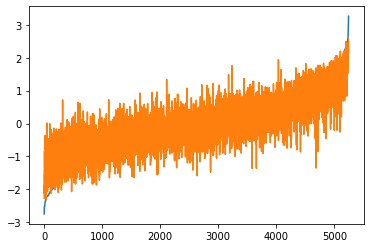

test


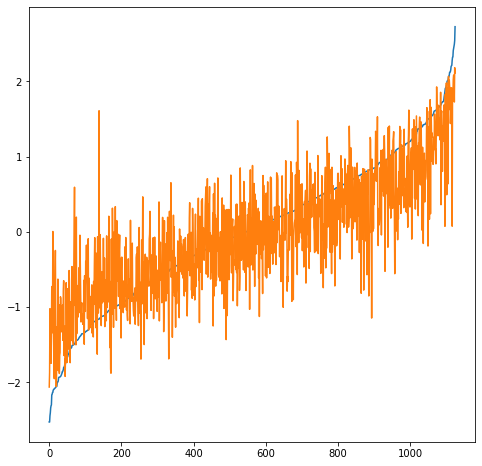

train real values log


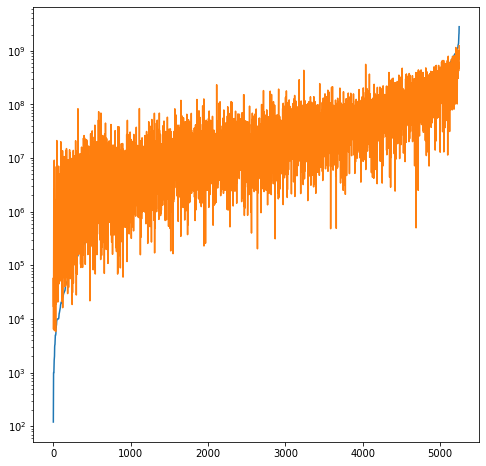

test real values log


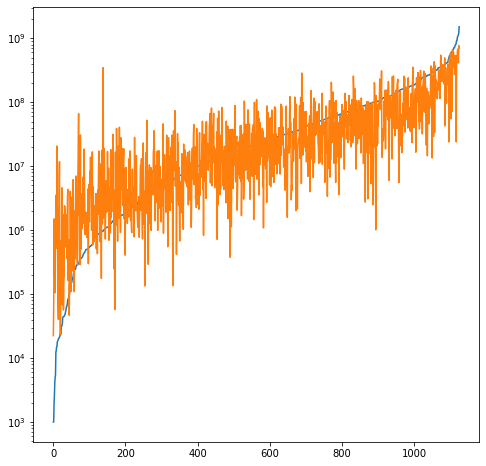

train real values


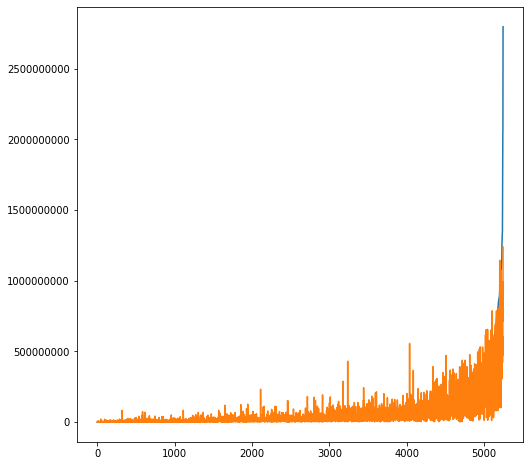

test real values


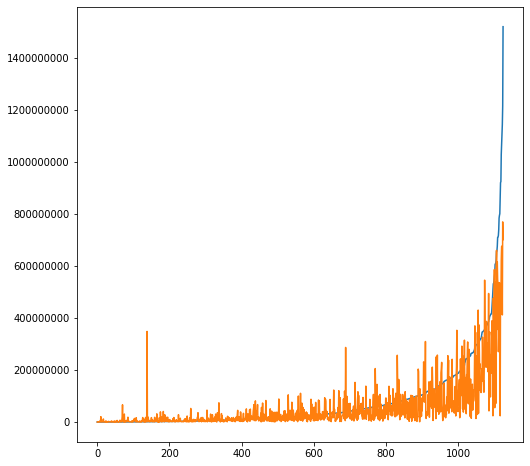

In [19]:
output_metrics(best_model, data, process)

In [48]:
adamax = keras.optimizers.Adamax(learning_rate=0.001,beta_1=0.95,beta_2=0.999)

def build_model():
  model = tf.keras.Sequential([
    Dense(
        256, 
        activation='sigmoid', 
        input_shape=[len(data['X_train'].keys())],
        kernel_initializer='glorot_normal',
        kernel_regularizer=keras.regularizers.l1_l2(l1=0.0001, l2=0.0001),
        bias_regularizer=keras.regularizers.l1_l2(l1=0.001, l2=0.1)
    ),
    Dropout(0.005),
    Dense(
        256, 
        activation='sigmoid',
        kernel_initializer='glorot_normal',
        kernel_regularizer=keras.regularizers.l1_l2(l1=0, l2=0.001),
        bias_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01),
    ),
    Dropout(0.5),  
    Dense(
        1,
        kernel_initializer='glorot_normal',
        activation='linear'
    )
  ])

  model.compile(loss='mse',
                optimizer=adamax,
                metrics=['mae', 'mse'])
  return model

model3 = build_model()
# model3.summary()

es = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=20)

history = model3.fit(
    data['X_train'], data['y_train'],
    epochs=1000, 
    validation_data=(data['X_test'], data['y_test']),
    verbose=0,
    batch_size=256,
    shuffle=True,
#     callbacks=[tfdocs.modeling.EpochDots(), es])
    callbacks=[es])

Epoch 00319: early stopping



Keras NN
train
mape: 2.3219739417293725
mae: 0.16243953913614914
rmse: 0.20757306312030505
adj_r2: 0.5939843487838716
test
mape: 3.0520191053653005
mae: 0.16026645579222148
rmse: 0.20362155082862923
adj_r2: 0.5056314213655961

Returned back

train
mape: 16.35778037172578
mae: 50595662.854966946
rmse: 133270305.42210619
adj_r2: 0.3649616274436579
test
mape: 12.278668953615476
mae: 47308181.072583385
rmse: 108124207.07238571
adj_r2: 0.34131264260824956
^^^^^^^^^^^^^^^^^^^^^^^^^^^^
nn
train


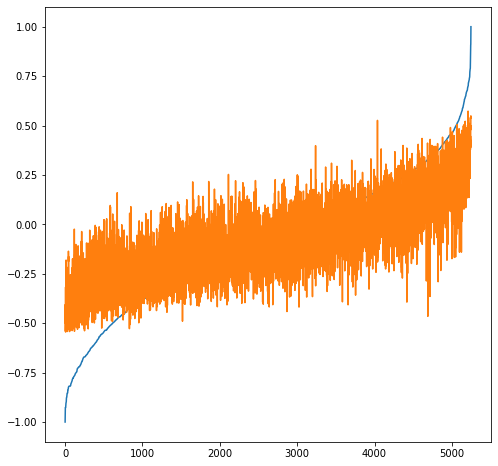

test


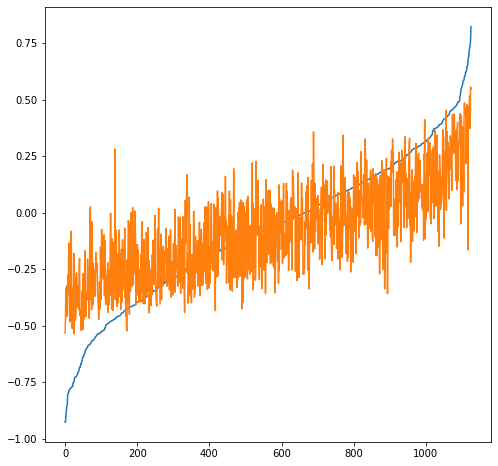

train real values log


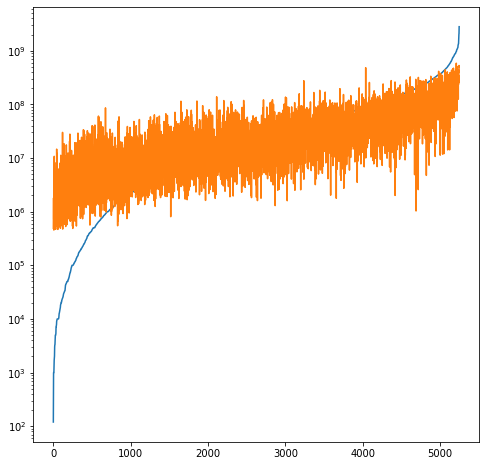

test real values log


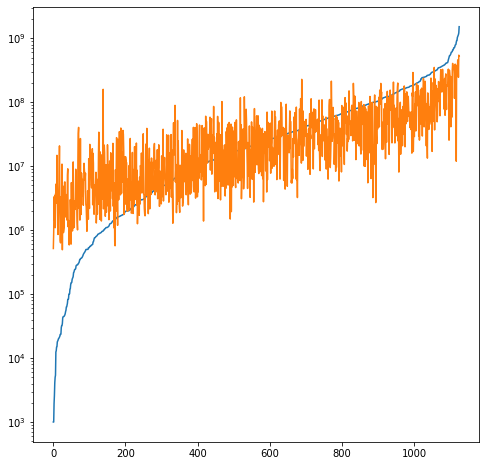

train real values


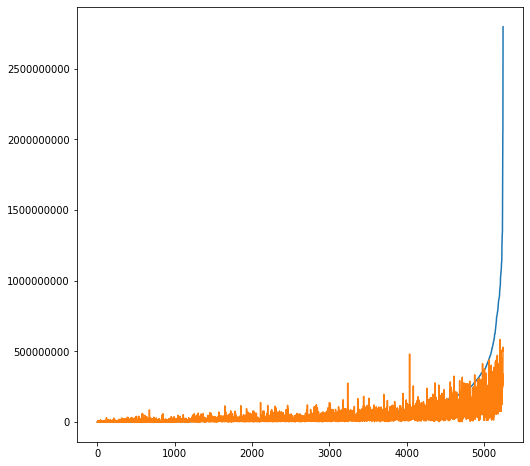

test real values


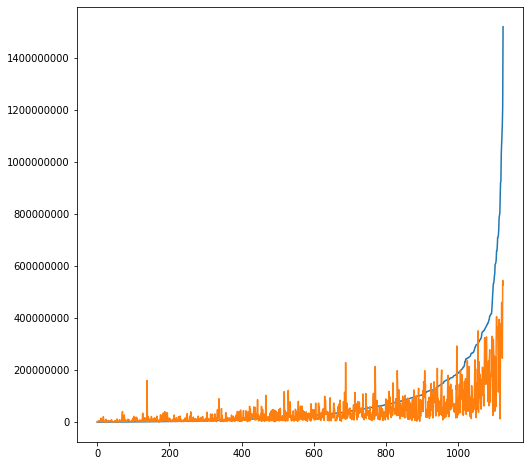

In [52]:
output_metrics(model3, data, process)

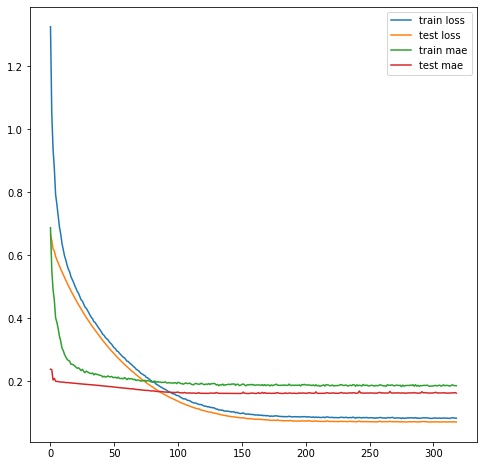

In [50]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train loss')
pyplot.plot(history.history['val_loss'], label='test loss')
pyplot.plot(history.history['mae'], label='train mae')
pyplot.plot(history.history['val_mae'], label='test mae')
pyplot.legend()
pyplot.show()

In [ ]:
def build_model():
  model = keras.Sequential([
#     layers.Dense(
#         64, 
#         activation='sigmoid', 
#         input_shape=[len(data['X_train'].keys())],
#         kernel_initializer=tf.keras.initializers.GlorotNormal()
#     ),
    layers.Dense(
        64, 
        activation='relu', 
        input_shape=[len(data['X_train'].keys())],
        kernel_initializer=tf.keras.initializers.he_normal()
    ),
    layers.Dropout(0.5),
#     layers.Dense(
#         64, 
#         activation='sigmoid',
#         kernel_initializer=tf.keras.initializers.GlorotNormal()
#     ),
    layers.Dense(
        64, 
        activation='relu',
        kernel_initializer=tf.keras.initializers.he_normal()
    ),
    layers.Dropout(0.5),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.Adam(0.001)
#   optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model2 = build_model()
model2.summary()

In [ ]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)

EPOCHS = 100

history = model2.fit(
  data['X_train'], data['y_train'],
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
#   callbacks=[tfdocs.modeling.EpochDots(), es])
  callbacks=[tfdocs.modeling.EpochDots()])

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train loss')
pyplot.plot(history.history['val_loss'], label='test loss')
# pyplot.plot(history.history['mse'], label='train mse')
# pyplot.plot(history.history['val_mse'], label='test mse')
# pyplot.plot(history.history['mae'], label='train mae')
# pyplot.plot(history.history['val_mae'], label='test mae')
pyplot.legend()
pyplot.show()

In [ ]:
output_metrics(model2, data, process)

In [ ]:
# relu wo initialization

# mape: 6.6013761902604395
# mae: 47785029.21390841
# rmse: 117085745.28254725
# adj_r2: 0.2683608578800275

In [ ]:
# sigmoid

# mape: 6.921294519771364
# mae: 46309187.6036963
# rmse: 106573312.92760979
# adj_r2: 0.39384203627853387

In [ ]:
# sigmoid initialization glorot

# mape: 5.891309178898037
# mae: 45178191.806934245
# rmse: 105538830.70659108
# adj_r2: 0.40555259042845115

In [ ]:
# relu initialization he-normal

# mape: 11.22876428439224
# mae: 49985922.89351641
# rmse: 124054429.88760668
# adj_r2: 0.1786780362328163

In [ ]:
# {'Dense': 1024,
#  'Dense_1': 256,
#  'Dense_2': 1024,
#  'Dropout': 0.15106219282775246,
#  'Dropout_1': 0.6763508226311498,
#  'Dropout_2': 'two',
#  'Dropout_3': 0.30987873188582754,
#  'batch_size': 256,
#  'choiceval': 'adam',
#  'lr': 0.001,
#  'lr_1': 0.01,
#  'lr_2': 0.1}

# mape: 14.735849474528678
# mae: 42425257.59364493
# rmse: 93314406.47801651
# adj_r2: 0.5986823964694081

In [ ]:
# {'Dense': 256,
#  'Dense_1': 1024,
#  'Dense_2': 1024,
#  'Dropout': 0.2974750265433348,
#  'Dropout_1': 0.39966419778642664,
#  'Dropout_2': 'two',
#  'Dropout_3': 0.526026582745637,
#  'activation': 'sigmoid',
#  'activation_1': 'sigmoid',
#  'activation_2': 'sigmoid',
#  'batch_size': 128,
#  'epochs': 75,
#  'kernel_initializer': <tensorflow.python.ops.init_ops_v2.VarianceScaling at 0x7f8b393ae710>,
#  'kernel_initializer_1': <tensorflow.python.ops.init_ops_v2.GlorotUniform at 0x7f8b393f3610>,
#  'kernel_initializer_2': <tensorflow.python.ops.init_ops_v2.VarianceScaling at 0x7f8b2aec9750>,
#  'optimizer': 'adam'}

# mape: 11.930947077248565
# mae: 41936947.39355901
# rmse: 94227681.26787286
# adj_r2: 0.5117092256416581

In [ ]:
# {'Dense': 256,
#  'Dense_1': 256,
#  'Dense_2': 1024,
#  'Dropout': 0.12206225819915595,
#  'Dropout_1': 0.197064731659927,
#  'Dropout_2': 'two',
#  'Dropout_3': 0.00029842311592569865,
#  'activation': 'sigmoid',
#  'activation_1': 'sigmoid',
#  'activation_2': 'relu',
#  'batch_size': 128,
#  'epochs': 25,
#  'kernel_initializer': 'glorot_normal',
#  'kernel_initializer_1': 'glorot_normal',
#  'kernel_initializer_2': 'glorot_uniform',
#  'optimizer': 'adam'}

# mape: 6.224157960480135
# mae: 43643280.72317956
# rmse: 99891850.23558912
# adj_r2: 0.5618906445214958

In [ ]:
# {'Dense': 512,
#  'Dense_1': 1024,
#  'Dense_2': 1024,
#  'Dropout': 0.003154114487844459,
#  'Dropout_1': 0.49453988643233404,
#  'Dropout_2': 'two',
#  'Dropout_3': 0.6057457357612506,
#  'activation': 'sigmoid',
#  'activation_1': 'sigmoid',
#  'activation_2': 'sigmoid',
#  'batch_size': 512,
#  'epochs': 100,
#  'kernel_initializer': 'glorot_normal',
#  'kernel_initializer_1': 'he_uniform',
#  'kernel_initializer_2': 'glorot_normal',
#  'optimizer': 'adam'}


# mape: 5.984611554637821
# mae: 43830607.21558445
# rmse: 99151995.47327316
# adj_r2: 0.5683563756398305

In [ ]:
# def build_model():
#   model = tf.keras.Sequential([
#     Dense(
#         512, 
#         activation='sigmoid', 
#         input_shape=[len(data['X_train'].keys())],
#         kernel_initializer='glorot_normal',
#         kernel_regularizer=keras.regularizers.l1_l2(l1=0.0001, l2=0.0001),
#         bias_regularizer=keras.regularizers.l1_l2(l1=0.001, l2=0.1)
#     ),
#     Dropout(0.005),
#     Dense(
#         1024, 
#         activation='sigmoid',
#         kernel_initializer='he_uniform',
#         kernel_regularizer=keras.regularizers.l1_l2(l1=0, l2=0.001),
#         bias_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01),
#         activity_regularizer=l1_l2(l1=0, l2=0.00001)
#     ),
#     Dropout(0.7), 
#     Dense(1)
#   ])

#   model.compile(loss='mean_squared_error',
#                 optimizer='adam',
#                 metrics=['mae', 'mean_squared_error'])
#   return model

# model3 = build_model()
# model3.summary()

# mape: 8.161095980091112
# mae: 35879531.109611064
# rmse: 87476559.6580578
# adj_r2: 0.5608763424966564

In [ ]:
# def build_model():
#   model = tf.keras.Sequential([
#     Dense(
#         256, 
#         activation='sigmoid', 
#         input_shape=[len(data['X_train'].keys())],
#         kernel_initializer='glorot_normal',
#         kernel_regularizer=keras.regularizers.l1_l2(l1=0.0001, l2=0.0001),
#         bias_regularizer=keras.regularizers.l1_l2(l1=0.001, l2=0.1)
#     ),
#     Dropout(0.005),
#     Dense(
#         256, 
#         activation='sigmoid',
#         kernel_initializer='glorot_normal',
#         kernel_regularizer=keras.regularizers.l1_l2(l1=0, l2=0.001),
#         bias_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01),
#     ),
#     Dropout(0.5),  
#     Dense(1)
#   ])

#   model.compile(loss='mae',
#                 optimizer='adam',
#                 metrics=['mae', 'mean_squared_error'])
#   return model

# model3 = build_model()
# # model3.summary()

# es = EarlyStopping(
#     monitor='val_loss', 
#     mode='min', 
#     verbose=1, 
#     patience=50)

# history = model3.fit(
#     data['X_train'], data['y_train'],
#     epochs=10000, 
#     validation_data=(data['X_test'], data['y_test']),
#     verbose=1,
#     batch_size=256,
#     shuffle=True,
# #     callbacks=[tfdocs.modeling.EpochDots(), es])
#     callbacks=[es])


# mape: 5.821131932635737
# mae: 42307258.2010261
# rmse: 95281127.2382761
# adj_r2: 0.4884981254695354

In [ ]:
# adamax = keras.optimizers.Adamax(learning_rate=0.001,beta_1=0.95,beta_2=0.999)

# def build_model():
#   model = tf.keras.Sequential([
#     Dense(
#         256, 
#         activation='sigmoid', 
#         input_shape=[len(data['X_train'].keys())],
#         kernel_initializer='glorot_normal',
#         kernel_regularizer=keras.regularizers.l1_l2(l1=0.0001, l2=0.0001),
#         bias_regularizer=keras.regularizers.l1_l2(l1=0.001, l2=0.1)
#     ),
#     Dropout(0.005),
#     Dense(
#         256, 
#         activation='sigmoid',
#         kernel_initializer='glorot_normal',
#         kernel_regularizer=keras.regularizers.l1_l2(l1=0, l2=0.001),
#         bias_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01),
#     ),
#     Dropout(0.5),  
#     Dense(
#         1,
#         kernel_initializer='glorot_normal',
#         activation='linear'
#     )
#   ])

#   model.compile(loss='mse',
#                 optimizer=adamax,
#                 metrics=['mae', 'mse'])
#   return model

# model3 = build_model()
# # model3.summary()

# es = EarlyStopping(
#     monitor='val_loss', 
#     mode='min', 
#     verbose=1, 
#     patience=20)

# history = model3.fit(
#     data['X_train'], data['y_train'],
#     epochs=1000, 
#     validation_data=(data['X_test'], data['y_test']),
#     verbose=0,
#     batch_size=256,
#     shuffle=True,
# #     callbacks=[tfdocs.modeling.EpochDots(), es])
#     callbacks=[es])

# mape: 6.094501890528896
# mae: 40504269.625439286
# rmse: 87054173.39806816
# adj_r2: 0.5730149701057303